In [1]:
%run main.py

1

In [ ]:
%run main.py


========= Round 0 =========


--- Step 0 ---

Training V1 solution by HJB
Iteration 0: Loss = 5.2905e+01
Iteration 1000: Loss = 6.3102e+00
Iteration 2000: Loss = 1.7896e+00
Iteration 3000: Loss = 6.7147e-01
Iteration 4000: Loss = 2.9731e-01
Iteration 5000: Loss = 1.0062e-01


Generating data...
Generated 10331 data from 32 BVP solutions in 24.4 sec 

Training V1 solution of BVP
Iteration 0: Loss_V = 3.2192e-02, Loss_V_x = 2.1002e-02, Loss_HJB = 2.8095e-01,  Loss_total = 3.3414e-01
Iteration 1000: Loss_V = 4.9905e-04, Loss_V_x = 1.0943e-03, Loss_HJB = 7.3770e-03,  Loss_total = 8.9704e-03
Iteration 2000: Loss_V = 1.6273e-04, Loss_V_x = 6.5639e-04, Loss_HJB = 3.9327e-03,  Loss_total = 4.7519e-03
Iteration 3000: Loss_V = 4.6117e-05, Loss_V_x = 6.0693e-04, Loss_HJB = 2.0140e-03,  Loss_total = 2.6670e-03
Iteration 4000: Loss_V = 1.2140e-05, Loss_V_x = 5.6899e-04, Loss_HJB = 1.1588e-03,  Loss_total = 1.7399e-03
Iteration 5000: Loss_V = 2.4905e-05, Loss_V_x = 5.4047e-04, Loss_HJB = 1.0554e-03

In [20]:
from model import *
from src.problem.prb import Analytic
import numpy as np
from src.problem.prb import Analytic
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#an = Analytic(device) 

data = np.load('data1.npz')
mu = torch.tensor(data['x'], dtype=torch.float32, device=device).mean(axis=0)
std = torch.sqrt(torch.tensor(data['x'], dtype=torch.float32, device=device).var(axis=0))

act_func=lambda x: torch.relu(x)

G_NN = G_Net(dim=2, ns=128, act_func=act_func, hh=0.5,
                            device=device, mu=mu, std=std,  TT=1).to(device)
    
G_NN.load_state_dict(torch.load('G_NNN_round0_n20.pth'))


<ipython-input-20-b79dbd8e9b0e>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G_NN.load_state_dict(torch.load('G_NNN_round0_n20.pth'))


<All keys matched successfully>

In [30]:
def gen_x0(num_samples, Torch=False):

        mu = np.array([[-0.75, 0.] + [0] * (10 - 2)], dtype=np.float32)
        samples = np.sqrt(0.01) * np.random.randn(num_samples, 10) + mu

        if Torch:
            return torch.tensor(samples, dtype=torch.float32, device=device)
        else:
            return samples


In [31]:
x = gen_x0(512, Torch=True).cpu().detach().numpy()
np.savez('data10.npz', x=x) 

In [32]:
data = np.load('data10.npz') 
x0_ini = torch.tensor(data['x'], dtype=torch.float32)
x0_ini.shape
x0_ini.mean(axis=0)

tensor([-0.7462, -0.0018, -0.0024, -0.0012,  0.0063,  0.0043,  0.0033, -0.0039,
        -0.0025, -0.0015])

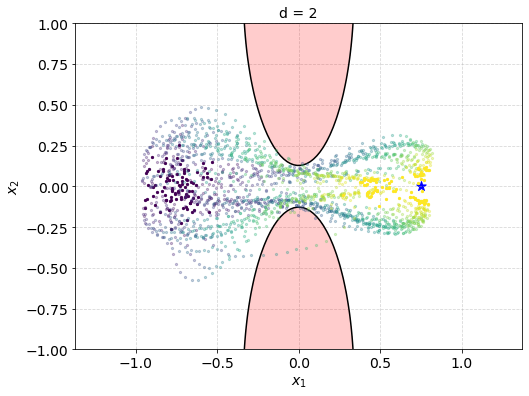

In [22]:
x_intia = gen_x0(100, Torch=True).cpu().detach().numpy()
#data = np.load('data_plot2.npz')
#x_intia = data['x_intia']
x_int = np.tile(x_intia, (21, 1))
x_test = torch.tensor(x_int, dtype=torch.float32, device=device)

t = torch.linspace(0,1.0, 21)
t_test = t.repeat_interleave(x_intia.shape[0]).view(-1,1)
t_test = torch.tensor(t_test, dtype=torch.float32, device=device)

x_out = G_NN(t_test, x_test).cpu().detach().numpy()
class ObstacleField:
    def __init__(self, linspace_size=100, lam_obstacle=1.0):
        self.linspace_size = linspace_size
        self.env = lambda: None
        self.env.lam_obstacle = lam_obstacle

    def FF_obstacle_func(self, x, y):
        """
        Two-diagonal obstacles confined to the interval [-1, 1] x [-1, 1].
        """
        theta = np.pi / 0.5
        rot_mat = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta),  np.cos(theta)]
        ], dtype=float)

        # Obstacle 1
        center1 = np.array([0., 0.3])
        vec1 = np.array([x, y]) - center1
        vec1 = np.dot(vec1, rot_mat)
        mat1 = np.array([[10, 0], [0, 1]])
        bb1 = np.array([0, 3])
        quad1 = np.dot(vec1, np.dot(mat1, vec1))
        lin1 = np.dot(vec1, bb1)
        out1 = np.clip(-1 * (quad1 + lin1 + 1), a_min=-0.1, a_max=None)

        # Obstacle 2
        center2 = np.array([0., -0.3])
        vec2 = np.array([x, y]) - center2
        vec2 = np.dot(vec2, rot_mat)
        mat2 = np.array([[10, 0], [0, 1]])
        bb2 = np.array([0, -3])
        quad2 = np.dot(vec2, np.dot(mat2, vec2))
        lin2 = np.dot(vec2, bb2)
        out2 = np.clip(-1 * (quad2 + lin2 + 1), a_min=-0.1, a_max=None)

        return out1 + out2

    def _make_obstacle_contours(self):
        self.plot_window_size = 1
        xlin = np.linspace(-self.plot_window_size, self.plot_window_size, self.linspace_size)
        ylin = np.linspace(-self.plot_window_size, self.plot_window_size, self.linspace_size)
        X, Y = np.meshgrid(xlin, ylin)
        vec_func = np.vectorize(self.FF_obstacle_func)
        Z = self.env.lam_obstacle * vec_func(X, Y)
        return X, Y, Z

def plot_trj(X_OUT):
    obstacle_field = ObstacleField()
    X_contour, Y_contour, Z_contour = obstacle_field._make_obstacle_contours()
    timesteps = 20

    fig, ax = plt.subplots(figsize=(8, 6))

    # Fill the interior of obstacles in red
    obstacle_levels = [0.001, np.max(Z_contour)]
    ax.contourf(
        X_contour, Y_contour, Z_contour,
        levels=obstacle_levels,
        colors='red',
        alpha=0.2,
        zorder=2
    )

    # Optional: draw obstacle boundaries
    ax.contour(
        X_contour, Y_contour, Z_contour,
        levels=[0],
        colors='black',
        linewidths=1.5,
        zorder=2
    )

    # Plot trajectory samples
    color = iter(cm.viridis(np.linspace(0, 1.0, timesteps + 1)))
    for time_idx in range(0, timesteps + 1):
        c = next(color)
        plot_sample = X_OUT.reshape(21, 100, 2)[time_idx, :, :]
        alpha = 1 if time_idx in {0, timesteps} else 0.3
        ax.scatter(plot_sample[:, 0], plot_sample[:, 1], color=c, alpha=alpha, zorder=10, s=5)

    # Target marker
    ax.scatter(0.75, 0.0, color="blue", marker="*", s=100)

    # Formatting
    ax.set_title("d = 2", fontsize=14)
    ax.set_xlabel(r'$x_1$', fontsize=14)
    ax.set_ylabel(r'$x_2$', fontsize=14)
    ax.axis("equal")
    ax.grid(True, linestyle="--", alpha=0.5)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.savefig('IGT_GEN_2.png', dpi=300)
    plt.show()
plot_trj(x_out)

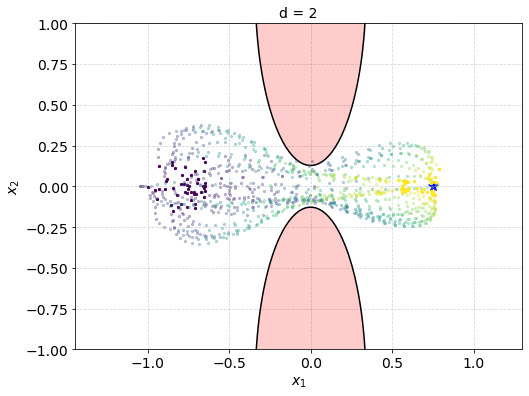

In [29]:
#x_intia = x_intia = gen_x0(50, Torch=True).cpu().detach().numpy()
data = np.load('data_plot2.npz')
x_intia = data['x_intia']
x_int = np.tile(x_intia, (21, 1))
x_test = torch.tensor(x_int, dtype=torch.float32, device=device)

t = torch.linspace(0,1.05, 21)
t_test = t.repeat_interleave(x_intia.shape[0]).view(-1,1)
t_test = torch.tensor(t_test, dtype=torch.float32, device=device)

x_out = G_NN(t_test, x_test).cpu().detach().numpy()
class ObstacleField:
    def __init__(self, linspace_size=100, lam_obstacle=1.0):
        self.linspace_size = linspace_size
        self.env = lambda: None
        self.env.lam_obstacle = lam_obstacle

    def FF_obstacle_func(self, x, y):
        """
        Two-diagonal obstacles confined to the interval [-1, 1] x [-1, 1].
        """
        theta = np.pi / 0.5
        rot_mat = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta),  np.cos(theta)]
        ], dtype=float)

        # Obstacle 1
        center1 = np.array([0., 0.3])
        vec1 = np.array([x, y]) - center1
        vec1 = np.dot(vec1, rot_mat)
        mat1 = np.array([[10, 0], [0, 1]])
        bb1 = np.array([0, 3])
        quad1 = np.dot(vec1, np.dot(mat1, vec1))
        lin1 = np.dot(vec1, bb1)
        out1 = np.clip(-1 * (quad1 + lin1 + 1), a_min=-0.1, a_max=None)

        # Obstacle 2
        center2 = np.array([0., -0.3])
        vec2 = np.array([x, y]) - center2
        vec2 = np.dot(vec2, rot_mat)
        mat2 = np.array([[10, 0], [0, 1]])
        bb2 = np.array([0, -3])
        quad2 = np.dot(vec2, np.dot(mat2, vec2))
        lin2 = np.dot(vec2, bb2)
        out2 = np.clip(-1 * (quad2 + lin2 + 1), a_min=-0.1, a_max=None)

        return out1 + out2

    def _make_obstacle_contours(self):
        self.plot_window_size = 1
        xlin = np.linspace(-self.plot_window_size, self.plot_window_size, self.linspace_size)
        ylin = np.linspace(-self.plot_window_size, self.plot_window_size, self.linspace_size)
        X, Y = np.meshgrid(xlin, ylin)
        vec_func = np.vectorize(self.FF_obstacle_func)
        Z = self.env.lam_obstacle * vec_func(X, Y)
        return X, Y, Z

def plot_trj(X_OUT):
    obstacle_field = ObstacleField()
    X_contour, Y_contour, Z_contour = obstacle_field._make_obstacle_contours()
    timesteps = 20

    fig, ax = plt.subplots(figsize=(8, 6))

    # Fill the interior of obstacles in red
    obstacle_levels = [0.001, np.max(Z_contour)]
    ax.contourf(
        X_contour, Y_contour, Z_contour,
        levels=obstacle_levels,
        colors='red',
        alpha=0.2,
        zorder=2
    )

    # Optional: draw obstacle boundaries
    ax.contour(
        X_contour, Y_contour, Z_contour,
        levels=[0],
        colors='black',
        linewidths=1.5,
        zorder=2
    )

    # Plot trajectory samples
    color = iter(cm.viridis(np.linspace(0, 1.0, timesteps + 1)))
    for time_idx in range(0, timesteps + 1):
        c = next(color)
        plot_sample = X_OUT.reshape(21, 50, 2)[time_idx, :, :]
        alpha = 1 if time_idx in {0, timesteps} else 0.3
        ax.scatter(plot_sample[:, 0], plot_sample[:, 1], color=c, alpha=alpha, zorder=10, s=5)

    # Target marker
    ax.scatter(0.75, 0.0, color="blue", marker="*", s=100)

    # Formatting
    ax.set_title("d = 2", fontsize=14)
    ax.set_xlabel(r'$x_1$', fontsize=14)
    ax.set_ylabel(r'$x_2$', fontsize=14)
    ax.axis("equal")
    ax.grid(True, linestyle="--", alpha=0.5)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.savefig('IGT_GEN_2.png', dpi=300)
    plt.show()
plot_trj(x_out)

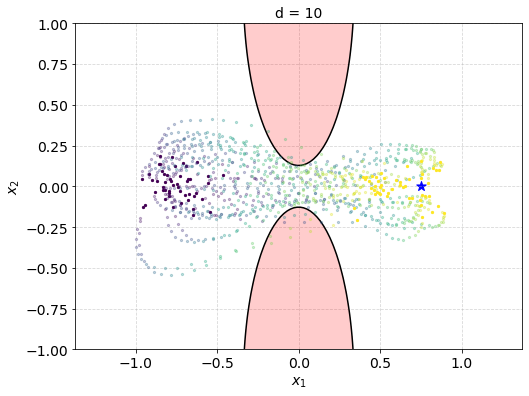

In [12]:
np.savez('data_plot2_50.npz', x_intia=x_intia) 

In [30]:
import os
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter, PillowWriter
import imageio_ffmpeg

def animate_trajectory_save_mp4(X_OUT, fps=10):
    """
    Create and save trajectory animation as MP4 in the current working directory.
    Falls back to GIF if ffmpeg is not available.
    
    Parameters:
        X_OUT (np.ndarray or torch.Tensor): Flattened trajectory array of shape [(T+1)*N, 2].
        fps (int): Frames per second for the output video.
    """
    # Initialize obstacle field (ensure ObstacleField is imported in your environment)
    obstacle_field = ObstacleField()
    Xc, Yc, Zc = obstacle_field._make_obstacle_contours()

    # Determine number of timesteps and reshape
    total_points = X_OUT.shape[0]
    # assume N = number of points per frame = total_points / (timesteps+1)
    # here we infer timesteps from X_OUT shape
    # if you know timesteps explicitly, set timesteps directly
    N = X_OUT.shape[1] if X_OUT.ndim > 1 else 2  # fallback if needed
    timesteps = int(total_points / N) - 1
    trajectory_data = X_OUT.reshape(timesteps + 1, -1, 2)

    # Setup plot
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.contour(Xc, Yc, Zc, levels=[0], colors="black", linewidths=2, zorder=1)
    ax.set_title("Trajectory Simulation", fontsize=14)
    ax.set_xlabel("X", fontsize=12)
    ax.set_ylabel("Y", fontsize=12)
    ax.axis("equal")
    ax.grid(True, linestyle="--", alpha=0.5)

    scatter = ax.scatter([], [], s=5, zorder=10)

    def update(frame):
        pts = trajectory_data[frame]
        scatter.set_offsets(pts)
        scatter.set_color(plt.cm.rainbow(frame / timesteps))
        return scatter,

    anim = FuncAnimation(fig, update, frames=range(timesteps + 1), blit=True)

    # Filenames in current directory
    cwd = os.getcwd()
    mp4_filename = "trajectory.mp4"
    mp4_path = os.path.join(cwd, mp4_filename)
    gif_filename = "trajectory.gif"
    gif_path = os.path.join(cwd, gif_filename)

    # Try saving as MP4
    try:
        writer = FFMpegWriter(fps=fps, codec='h264', extra_args=['-pix_fmt', 'yuv420p'])
        anim.save(mp4_path, writer=writer)
        plt.close(fig)
        print(f"Animation saved as MP4 in directory: {cwd}")
    except (FileNotFoundError, RuntimeError):
        # Fallback to GIF
        writer = PillowWriter(fps=fps)
        anim.save(gif_path, writer=writer)
        plt.close(fig)
        print(f"ffmpeg not found; animation saved as GIF in directory: {cwd}")

# Example usage:
# animate_trajectory_save_mp4(x_out, fps=20)


In [31]:
animate_trajectory_save_mp4(x_out, fps=5)



ffmpeg not found; animation saved as GIF in directory: /home/mouhcine.assouli/IGT_GEN_Obstacl_D_new2


In [22]:
pip install imageio-ffmpeg

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 16.5 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.3.2 -> 25.0.1
[notice] To update, run: /srv/software/easybuild/software/Anaconda3/2020.11/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [37]:
from IPython.display import HTML
import os

def animate_trajectory(X_OUT, filename="trajectory.html"):
    # Initialize obstacle field
    obstacle_field = ObstacleField()

    # Generate contours
    X_contour, Y_contour, Z_contour = obstacle_field._make_obstacle_contours()

    timesteps = 20
    trajectory_data = X_OUT.reshape(timesteps + 1, -1, 2)  # Adjust dimensions if needed

    # Plot setup
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.contour(X_contour, Y_contour, Z_contour, levels=[0], colors="black", linewidths=2, zorder=1)
    ax.set_title("Trajectory Simulation", fontsize=14)
    ax.set_xlabel("X", fontsize=12)
    ax.set_ylabel("Y", fontsize=12)
    ax.axis("equal")
    ax.grid(True, linestyle="--", alpha=0.5)

    # Plot initialization
    scatter = ax.scatter([], [], s=5, zorder=10)

    # Update function for animation
    def update(frame):
        data = trajectory_data[frame]
        scatter.set_offsets(data)
        scatter.set_color(cm.rainbow(frame / timesteps))
        return scatter,

    # Create animation
    anim = FuncAnimation(fig, update, frames=range(timesteps + 1), blit=True)

    # Export to HTML5 string
    html_str = anim.to_jshtml()

    # Save to file in current directory
    with open(filename, "w") as f:
        f.write(html_str)

    cwd = os.getcwd()
    print(f"Animation HTML saved as '{filename}' in directory: {cwd}")

    plt.close(fig)
    return HTML(html_str)


In [38]:
animate_trajectory(x_out, filename="trajectory.html")

Animation HTML saved as 'trajectory.html' in directory: /home/mouhcine.assouli/IGT_GEN_Obstacl_D_new2


NameError: name 'filename' is not defined

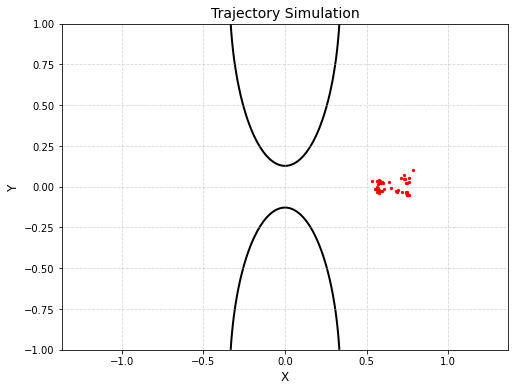

In [36]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm


# Assuming ObstacleField is already defined

def animate_trajectory(X_OUT):
    # Initialize obstacle field
    obstacle_field = ObstacleField()

    # Generate contours
    X_contour, Y_contour, Z_contour = obstacle_field._make_obstacle_contours()

    timesteps = 20
    trajectory_data = X_OUT.reshape(timesteps + 1, -1, 2)  # Adjust dimensions if needed

    # Plot setup
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.contour(X_contour, Y_contour, Z_contour, levels=[0], colors="black", linewidths=2, zorder=1)
    ax.set_title("Trajectory Simulation", fontsize=14)
    ax.set_xlabel("X", fontsize=12)
    ax.set_ylabel("Y", fontsize=12)
    ax.axis("equal")
    ax.grid(True, linestyle="--", alpha=0.5)

    # Plot initialization
    scatter = ax.scatter([], [], s=5, zorder=10)

    # Update function for animation
    def update(frame):
        data = trajectory_data[frame]
        scatter.set_offsets(data)
        scatter.set_color(cm.rainbow(frame / timesteps))
        return scatter,

    # Create animation
    anim = FuncAnimation(fig, update, frames=range(timesteps + 1), blit=True)
    
    # Generate the HTML representation
    html_str = anim.to_jshtml()

    # Save HTML to file
    with open(filename, "w") as f:
        f.write(html_str)

    plt.close(fig)
    cwd = os.getcwd()
    print(f"Animation HTML saved as in directory")


    # Display animation inline
    return HTML(anim.to_jshtml())


# Generate video
animate_trajectory(x_out)

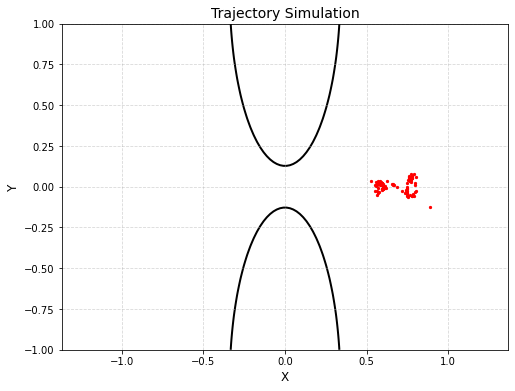

In [8]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm


# Assuming ObstacleField is already defined

def animate_trajectory(X_OUT):
    # Initialize obstacle field
    obstacle_field = ObstacleField()

    # Generate contours
    X_contour, Y_contour, Z_contour = obstacle_field._make_obstacle_contours()

    timesteps = 20
    trajectory_data = X_OUT.reshape(timesteps + 1, -1, 2)  # Adjust dimensions if needed

    # Plot setup
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.contour(X_contour, Y_contour, Z_contour, levels=[0], colors="black", linewidths=2, zorder=1)
    ax.set_title("Trajectory Simulation", fontsize=14)
    ax.set_xlabel("X", fontsize=12)
    ax.set_ylabel("Y", fontsize=12)
    ax.axis("equal")
    ax.grid(True, linestyle="--", alpha=0.5)

    # Plot initialization
    scatter = ax.scatter([], [], s=5, zorder=10)

    # Update function for animation
    def update(frame):
        data = trajectory_data[frame]
        scatter.set_offsets(data)
        scatter.set_color(cm.rainbow(frame / timesteps))
        return scatter,

    # Create animation
    anim = FuncAnimation(fig, update, frames=range(timesteps + 1), blit=True)

    # Display animation inline
    return HTML(anim.to_jshtml())


# Generate video
animate_trajectory(x_out)

In [ ]:
%run main.py 
#dim=4


========= Round 2 =========


--- Step 0 ---

Training V1 solution by HJB
Iteration 0: Loss = 3.4470e+01
Iteration 1000: Loss = 4.2137e+00
Iteration 2000: Loss = 1.2873e+00
Iteration 3000: Loss = 3.1442e-01
Iteration 4000: Loss = 1.0356e-01
Iteration 5000: Loss = 9.2699e-02


Generating data...
Solver failed (1/31): The maximum number of mesh nodes is exceeded.
Iteration 0: Loss = 1.1897e-01
Iteration 1000: Loss = 1.6311e-02


Solver failed (2/31): The maximum number of mesh nodes is exceeded.
Iteration 0: Loss = 3.4618e-02
Iteration 1000: Loss = 9.8638e-03


Solver failed (3/31): The maximum number of mesh nodes is exceeded.
Iteration 0: Loss = 1.3706e-01
Iteration 1000: Loss = 5.7075e-03


Solver failed (4/30): The maximum number of mesh nodes is exceeded.
Iteration 0: Loss = 2.1375e-02
Iteration 1000: Loss = 6.7636e-03


Solver failed (5/30): The maximum number of mesh nodes is exceeded.
Iteration 0: Loss = 4.4546e-02


In [1]:
%run main.py


========= Round 2 =========


--- Step 0 ---

Training V1 solution by HJB
Iteration 0: Loss = 3.9766e+01


KeyboardInterrupt: 

torch.Size([264, 2])
torch.Size([264, 4])


In [27]:
from model import *
from src.problem.prb import Analytic
import numpy as np
from src.problem.prb import Analytic
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#an = Analytic(device) 

data = np.load('data2.npz')
mu = torch.tensor(data['x'], dtype=torch.float32, device=device).mean(axis=0)
std = torch.sqrt(torch.tensor(data['x'], dtype=torch.float32, device=device).var(axis=0))

act_func=lambda x: torch.relu(x)

G_NN = G_Net(dim=4, ns=128, act_func=act_func, hh=0.5,
                            device=device, mu=mu, std=std,  TT=1).to(device)
    
G_NN.load_state_dict(torch.load('G_NN2_round2_n8.pth'))

<All keys matched successfully>

In [28]:
def gen_x0(num_samples, Torch=False):

        mu = np.array([[-0.75, 0.] + [0] * (4 - 2)], dtype=np.float32)
        samples = np.sqrt(0.01) * np.random.randn(num_samples, 4) + mu

        if Torch:
            return torch.tensor(samples, dtype=torch.float32, device=device)
        else:
            return samples

In [29]:
x_intia = gen_x0(50, Torch=True).cpu().detach().numpy()
x_int = np.tile(x_intia, (21, 1))
x_test = torch.tensor(x_int, dtype=torch.float32, device=device)

t = torch.linspace(0,1.0, 21)
t_test = t.repeat_interleave(x_intia.shape[0]).view(-1,1)
t_test = torch.tensor(t_test, dtype=torch.float32, device=device)

x_out = G_NN(t_test, x_test).cpu().detach().numpy()


In [30]:
class ObstacleField:
    def __init__(self, linspace_size=100, lam_obstacle=1.0):
        self.linspace_size = linspace_size
        self.env = lambda: None
        self.env.lam_obstacle = lam_obstacle

    def circular_obstacle(self, x, y, center, radius):
        """
        Defines a circular obstacle.
        """
        dist_squared = (x - center[0])**2 + (y - center[1])**2
        return radius**2 - dist_squared

    def smooth_max(self, f1, f2, smoothness=50.0):
        return (1 / smoothness) * np.log(np.exp(smoothness * f1) + np.exp(smoothness * f2))

#     def FF_obstacle_func(self, x, y):
#         """
#         Combines two circular obstacles with smooth maximum.
#         """
#         obstacle1 = self.circular_obstacle(x, y, center=[0., 0.65], radius=0.5)
#         obstacle2 = self.circular_obstacle(x, y, center=[0., -0.65], radius=0.5)

# #         obstacle1 = self.circular_obstacle(x, y, center=[0.1, 0.6], radius=0.5)
# #         obstacle2 = self.circular_obstacle(x, y, center=[0.1, -0.7], radius=0.7)
#         return np.maximum(obstacle1, obstacle2)

    def FF_obstacle_func(self, x, y):
        """
        Two-diagonal obstacles confined to the interval [-1, 1] x [-1, 1].
        """
        # Rotation matrix for diagonal obstacles (rotated by 36 degrees)
        theta = np.pi / 0.5
        rot_mat = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]], dtype=float)

        # Bottom/Left obstacle (adjusted center and scaling for [-1, 1] x [-1, 1])
        center1 = np.array([-0., 0.3], dtype=float)  # Center shifted within [-1, 1]
        vec1 = np.array([x, y], dtype=float) - center1
        vec1 = np.dot(vec1, rot_mat)  # Apply rotation
        mat1 = np.array([[10, 0], [0, 1]], dtype=float)  # Adjust scaling for [-1, 1]
        bb1 = np.array([0, 3], dtype=float)  # Adjust slope/linear term
        quad1 = np.dot(vec1, np.dot(mat1, vec1))
        lin1 = np.dot(vec1, bb1)
        out1 = np.clip((-1) * (quad1 + lin1 + 1), a_min=-0.1, a_max=None)

        # Top/Right obstacle (adjusted center and scaling for [-1, 1] x [-1, 1])
        center2 = np.array([0., -0.3], dtype=float)  # Center shifted within [-1, 1]
        vec2 = np.array([x, y], dtype=float) - center2
        vec2 = np.dot(vec2, rot_mat)  # Apply rotation
        mat2 = np.array([[10, 0], [0, 1]], dtype=float)  # Adjust scaling for [-1, 1]
        bb2 = np.array([0, -3], dtype=float)  # Adjust slope/linear term
        quad2 = np.dot(vec2, np.dot(mat2, vec2))
        lin2 = np.dot(vec2, bb2)
        out2 = np.clip((-1) * (quad2 + lin2 + 1), a_min=-0.1, a_max=None)

        # Combine the two obstacles
        out = out1 + out2

        return out
    
    def _make_obstacle_contours(self):
        """
        Precomputes the obstacle contour.
        """
        self.plot_window_size = 1  # plot window size
        xlin = np.linspace(-self.plot_window_size, self.plot_window_size, self.linspace_size)
        ylin = np.linspace(-self.plot_window_size, self.plot_window_size, self.linspace_size)
        X, Y = np.meshgrid(xlin, ylin)
        vec_func = np.vectorize(self.FF_obstacle_func)
        Z = self.env.lam_obstacle * vec_func(X, Y)

        return X, Y, Z

#     def _make_obstacle_contours(self):
#         """
#         Prepares contour grid for obstacle field visualization.
#         """
#         self.plot_window_size = 1.5
#         xlin = np.linspace(-self.plot_window_size, self.plot_window_size, self.linspace_size)
#         ylin = np.linspace(-self.plot_window_size, self.plot_window_size, self.linspace_size)
#         X, Y = np.meshgrid(xlin, ylin)
#         vec_func = np.vectorize(self.FF_obstacle_func)
#         Z = self.env.lam_obstacle * vec_func(X, Y)
#         return X, Y, Z

def plot_trj(X_OUT):
    # Initialize obstacle field
    obstacle_field = ObstacleField()

    # Generate contours
    X_contour, Y_contour, Z_contour = obstacle_field._make_obstacle_contours()

    timesteps = 20

    # Define obstacle properties
#     obstacles = [
#         {"center": [0., 0.65], "radius": 0.5},
#         {"center": [0., -0.65], "radius": 0.5},
#     ]

    # Plot setup
    fig, ax = plt.subplots(figsize=(8, 6))

    # Add contour lines for obstacles
    ax.contour(
        X_contour, Y_contour, Z_contour, 
        levels=[0], 
        colors="black", 
        linewidths=2, 
        zorder=1
    )

    # Add filled circles for obstacles
#     for obs in obstacles:
#         circle = plt.Circle(obs["center"], obs["radius"], color="red", alpha=0.2, zorder=2)
#         ax.add_patch(circle)

    # Plot the trajectory
    color = iter(cm.rainbow(np.linspace(0, 1.0, timesteps + 1)))
    #next(color)  # Skip the first color

    for time_idx in range(0, timesteps + 1):
        c = next(color)
        plot_sample = X_OUT.reshape(21, 50, 4)[time_idx, : , :]  # Adjust for trajectory dimensions
        alpha = 1 if time_idx in {0, timesteps} else 0.3
        ax.scatter(plot_sample[:, 0], plot_sample[:, 1], color=c, alpha=alpha, zorder=10, s=5)

    # Mark specific points
    #ax.scatter(6.95185290e-01, -2.03101843e-02, color="blue", marker="x", s=100)
    ax.scatter(0.75, 0.0, color="blue", marker="*", s=100)

    # Adjust plot limits and labels
    ax.set_title("Trajectory with Circular Obstacles (d=2)", fontsize=14)
    ax.set_xlabel("X", fontsize=12)
    ax.set_ylabel("Y", fontsize=12)
    ax.axis("equal")
    ax.grid(True, linestyle="--", alpha=0.5)

    # Save and display the plot
    plt.savefig("trajectory_with_obstacles.png", dpi=300)
    #plt.show()

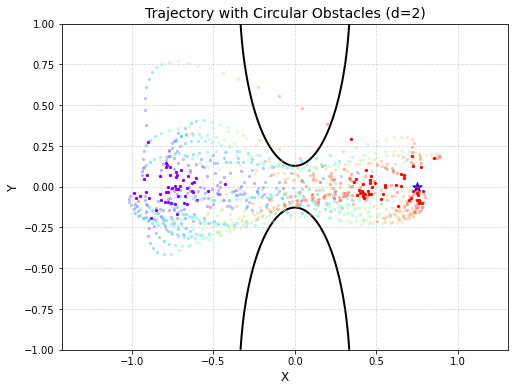

In [31]:
plot_trj(x_out)

In [1]:
%run main.py
#dim=10


========= Round 2 =========


--- Step 0 ---

Training V1 solution by HJB
Iteration 0: Loss = 4.8678e+01


KeyboardInterrupt: 

In [247]:
from model import *
from src.problem.prb import Analytic
import numpy as np
from src.problem.prb import Analytic
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib import cm
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#an = Analytic(device) 

data = np.load('data3.npz')
mu = torch.tensor(data['x'], dtype=torch.float32, device=device).mean(axis=0)
std = torch.sqrt(torch.tensor(data['x'], dtype=torch.float32, device=device).var(axis=0))

act_func=lambda x: torch.relu(x)

G_NN = G_Net(dim=10, ns=128, act_func=act_func, hh=0.5,
                            device=device, mu=mu, std=std,  TT=1).to(device)
    
G_NN.load_state_dict(torch.load('G_NN3_round2_n6.pth'))

<All keys matched successfully>

In [248]:
def gen_x0(num_samples, Torch=False):

        mu = np.array([[-0.75, 0.] + [0] * (10 - 2)], dtype=np.float32)
        samples = np.sqrt(0.01) * np.random.randn(num_samples, 10) + mu

        if Torch:
            return torch.tensor(samples, dtype=torch.float32, device=device)
        else:
            return samples

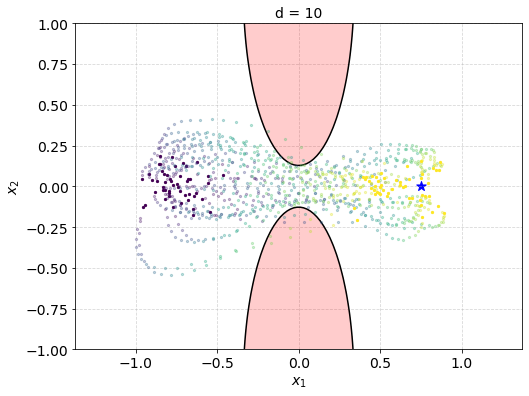

In [250]:
data = np.load('data_plot10.npz')
x_intia = data['x_intia']
x_int = np.tile(x_intia, (21, 1))
x_test = torch.tensor(x_int, dtype=torch.float32, device=device)

t = torch.linspace(0,1.0, 21)
t_test = t.repeat_interleave(x_intia.shape[0]).view(-1,1)
t_test = torch.tensor(t_test, dtype=torch.float32, device=device)

x_out = G_NN(t_test, x_test).cpu().detach().numpy()

class ObstacleField:
    def __init__(self, linspace_size=100, lam_obstacle=1.0):
        self.linspace_size = linspace_size
        self.env = lambda: None
        self.env.lam_obstacle = lam_obstacle

    def circular_obstacle(self, x, y, center, radius):
        """
        Defines a circular obstacle.
        """
        dist_squared = (x - center[0])**2 + (y - center[1])**2
        return radius**2 - dist_squared

    def smooth_max(self, f1, f2, smoothness=50.0):
        return (1 / smoothness) * np.log(np.exp(smoothness * f1) + np.exp(smoothness * f2))


    def FF_obstacle_func(self, x, y):
        """
        Two-diagonal obstacles confined to the interval [-1, 1] x [-1, 1].
        """
        # Rotation matrix for diagonal obstacles (rotated by 36 degrees)
        theta = np.pi / 0.5
        rot_mat = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]], dtype=float)

        # Bottom/Left obstacle (adjusted center and scaling for [-1, 1] x [-1, 1])
        center1 = np.array([-0., 0.3], dtype=float)  # Center shifted within [-1, 1]
        vec1 = np.array([x, y], dtype=float) - center1
        vec1 = np.dot(vec1, rot_mat)  # Apply rotation
        mat1 = np.array([[10, 0], [0, 1]], dtype=float)  # Adjust scaling for [-1, 1]
        bb1 = np.array([0, 3], dtype=float)  # Adjust slope/linear term
        quad1 = np.dot(vec1, np.dot(mat1, vec1))
        lin1 = np.dot(vec1, bb1)
        out1 = np.clip((-1) * (quad1 + lin1 + 1), a_min=-0.1, a_max=None)

        # Top/Right obstacle (adjusted center and scaling for [-1, 1] x [-1, 1])
        center2 = np.array([0., -0.3], dtype=float)  # Center shifted within [-1, 1]
        vec2 = np.array([x, y], dtype=float) - center2
        vec2 = np.dot(vec2, rot_mat)  # Apply rotation
        mat2 = np.array([[10, 0], [0, 1]], dtype=float)  # Adjust scaling for [-1, 1]
        bb2 = np.array([0, -3], dtype=float)  # Adjust slope/linear term
        quad2 = np.dot(vec2, np.dot(mat2, vec2))
        lin2 = np.dot(vec2, bb2)
        out2 = np.clip((-1) * (quad2 + lin2 + 1), a_min=-0.1, a_max=None)

        # Combine the two obstacles
        out = out1 + out2

        return out
    
    def _make_obstacle_contours(self):
        """
        Precomputes the obstacle contour.
        """
        self.plot_window_size = 1  # plot window size
        xlin = np.linspace(-self.plot_window_size, self.plot_window_size, self.linspace_size)
        ylin = np.linspace(-self.plot_window_size, self.plot_window_size, self.linspace_size)
        X, Y = np.meshgrid(xlin, ylin)
        vec_func = np.vectorize(self.FF_obstacle_func)
        Z = self.env.lam_obstacle * vec_func(X, Y)

        return X, Y, Z

def plot_trj(X_OUT):
    obstacle_field = ObstacleField()
    X_contour, Y_contour, Z_contour = obstacle_field._make_obstacle_contours()
    timesteps = 20

    fig, ax = plt.subplots(figsize=(8, 6))

    # Fill the interior of obstacles in red
    obstacle_levels = [0.001, np.max(Z_contour)]
    ax.contourf(
        X_contour, Y_contour, Z_contour,
        levels=obstacle_levels,
        colors='red',
        alpha=0.2,
        zorder=2
    )

    # Optional: draw obstacle boundaries
    ax.contour(
        X_contour, Y_contour, Z_contour,
        levels=[0],
        colors='black',
        linewidths=1.5,
        zorder=2
    )

    # Plot trajectory samples
    color = iter(cm.viridis(np.linspace(0, 1.0, timesteps + 1)))
    for time_idx in range(0, timesteps + 1):
        c = next(color)
        plot_sample = X_OUT.reshape(21, 50, 10)[time_idx, :, :]
        alpha = 1 if time_idx in {0, timesteps} else 0.3
        ax.scatter(plot_sample[:, 0], plot_sample[:, 1], color=c, alpha=alpha, zorder=10, s=5)

    # Target marker
    ax.scatter(0.75, 0.0, color="blue", marker="*", s=100)

    # Formatting
    ax.set_title("d = 10", fontsize=14)
    ax.set_xlabel(r'$x_1$', fontsize=14)
    ax.set_ylabel(r'$x_2$', fontsize=14)
    ax.axis("equal")
    ax.grid(True, linestyle="--", alpha=0.5)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.savefig('IGT_GEN_10.png', dpi=300)
    plt.show()
plot_trj(x_out)

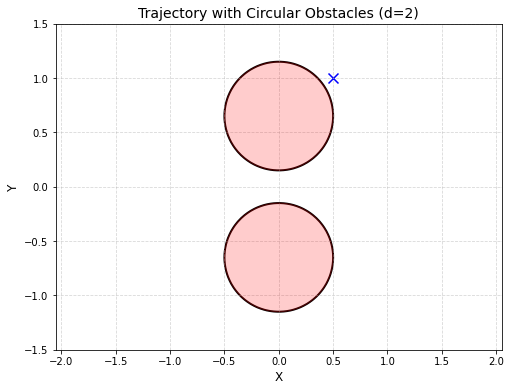

In [11]:
class ObstacleField:
    def __init__(self, linspace_size=100, lam_obstacle=1.0):
        self.linspace_size = linspace_size
        self.env = lambda: None
        self.env.lam_obstacle = lam_obstacle

    def circular_obstacle(self, x, y, center, radius):
        """
        Defines a circular obstacle.
        """
        dist_squared = (x - center[0])**2 + (y - center[1])**2
        return radius**2 - dist_squared

    def smooth_max(self, f1, f2, smoothness=50.0):
        return (1 / smoothness) * np.log(np.exp(smoothness * f1) + np.exp(smoothness * f2))

    def FF_obstacle_func(self, x, y):
        """
        Combines two circular obstacles with smooth maximum.
        """
        obstacle1 = self.circular_obstacle(x, y, center=[0., 0.65], radius=0.5)
        obstacle2 = self.circular_obstacle(x, y, center=[0, -0.65], radius=0.5)

#         obstacle1 = self.circular_obstacle(x, y, center=[0.1, 0.6], radius=0.5)
#         obstacle2 = self.circular_obstacle(x, y, center=[0.1, -0.7], radius=0.7)
        return np.maximum(obstacle1, obstacle2)

    def _make_obstacle_contours(self):
        """
        Prepares contour grid for obstacle field visualization.
        """
        self.plot_window_size = 1.5
        xlin = np.linspace(-self.plot_window_size, self.plot_window_size, self.linspace_size)
        ylin = np.linspace(-self.plot_window_size, self.plot_window_size, self.linspace_size)
        X, Y = np.meshgrid(xlin, ylin)
        vec_func = np.vectorize(self.FF_obstacle_func)
        Z = self.env.lam_obstacle * vec_func(X, Y)
        return X, Y, Z


# Initialize obstacle field
obstacle_field = ObstacleField()

# Generate contours
X_contour, Y_contour, Z_contour = obstacle_field._make_obstacle_contours()

timesteps = 20

# Define obstacle properties
obstacles = [
    {"center": [0., 0.65], "radius": 0.5},
    {"center": [0., -0.65], "radius": 0.5},
]

# Plot setup
fig, ax = plt.subplots(figsize=(8, 6))

# Add contour lines for obstacles
ax.contour(
    X_contour, Y_contour, Z_contour, 
    levels=[0], 
    colors="black", 
    linewidths=2, 
    zorder=1
)

# Add filled circles for obstacles
for obs in obstacles:
    circle = plt.Circle(obs["center"], obs["radius"], color="red", alpha=0.2, zorder=2)
    ax.add_patch(circle)

# Plot the trajectory
color = iter(cm.rainbow(np.linspace(0, 1, timesteps + 2)))
next(color)  # Skip the first color

# for time_idx in range(0, timesteps + 1):
#     c = next(color)
#     plot_sample = X_OUT.reshape(128, 21, 2)[0:64, time_idx, :]  # Adjust for trajectory dimensions
#     alpha = 1 if time_idx in {0, timesteps} else 0.3
#     ax.scatter(plot_sample[:, 0], plot_sample[:, 1], color=c, alpha=alpha, zorder=10, s=5)

# Mark specific points
ax.scatter(0.5, 1., color="blue", marker="x", s=100)

# Adjust plot limits and labels
ax.set_title("Trajectory with Circular Obstacles (d=2)", fontsize=14)
ax.set_xlabel("X", fontsize=12)
ax.set_ylabel("Y", fontsize=12)
ax.axis("equal")
ax.grid(True, linestyle="--", alpha=0.5)

# Save and display the plot
plt.savefig("trajectory_with_obstacles.png", dpi=300)
#plt.show()

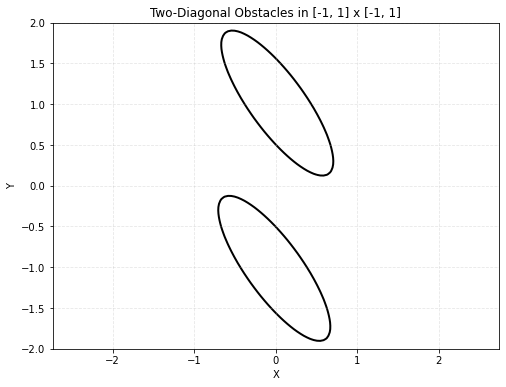

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt

class ObstacleField:
    def __init__(self, linspace_size=100, lam_obstacle=1.0):
        self.linspace_size = linspace_size
        self.env = lambda: None
        self.env.lam_obstacle = lam_obstacle
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def smooth_clamp_min(self, x, smoothness=20.0):
        return (1 / smoothness) * np.log(1 + np.exp(smoothness * x))

    def FF_obstacle_func(self, x, y):
        """
        Two-diagonal obstacles confined to the interval [-1, 1] x [-1, 1].
        """
        # Rotation matrix for diagonal obstacles (rotated by 36 degrees)
        theta = np.pi / 5
        rot_mat = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]], dtype=float)

        # Bottom/Left obstacle (adjusted center and scaling for [-1, 1] x [-1, 1])
        center1 = np.array([-0.9, 0.2], dtype=float)  # Center shifted within [-1, 1]
        vec1 = np.array([x, y], dtype=float) - center1
        vec1 = np.dot(vec1, rot_mat)  # Apply rotation
        mat1 = np.array([[10, 0], [0, 1]], dtype=float)  # Adjust scaling for [-1, 1]
        bb1 = np.array([0, 3], dtype=float)  # Adjust slope/linear term
        quad1 = np.dot(vec1, np.dot(mat1, vec1))
        lin1 = np.dot(vec1, bb1)
        out1 = np.clip((-1) * (quad1 + lin1 + 1), a_min=-0.1, a_max=None)

        # Top/Right obstacle (adjusted center and scaling for [-1, 1] x [-1, 1])
        center2 = np.array([0.9, -0.2], dtype=float)  # Center shifted within [-1, 1]
        vec2 = np.array([x, y], dtype=float) - center2
        vec2 = np.dot(vec2, rot_mat)  # Apply rotation
        mat2 = np.array([[10, 0], [0, 1]], dtype=float)  # Adjust scaling for [-1, 1]
        bb2 = np.array([0, -3], dtype=float)  # Adjust slope/linear term
        quad2 = np.dot(vec2, np.dot(mat2, vec2))
        lin2 = np.dot(vec2, bb2)
        out2 = np.clip((-1) * (quad2 + lin2 + 1), a_min=-0.1, a_max=None)

        # Combine the two obstacles
        out = out1 + out2

        return out

    def _make_obstacle_contours(self):
        """
        Precomputes the obstacle contour in the interval [-1, 1] x [-1, 1].
        """
        xlin = np.linspace(-2, 2, self.linspace_size)  # Constrain to [-1, 1]
        ylin = np.linspace(-2, 2, self.linspace_size)
        X, Y = np.meshgrid(xlin, ylin)

        vec_func = np.vectorize(lambda x, y: self.FF_obstacle_func(x, y))
        Z = self.env.lam_obstacle * vec_func(X, Y)

        return X, Y, Z


# Initialize ObstacleField
obstacle_field = ObstacleField(lam_obstacle=10)

# Generate contours
X_contour, Y_contour, Z_contour = obstacle_field._make_obstacle_contours()

# Plot setup
fig, ax = plt.subplots(figsize=(8, 6))
contour = ax.contour(X_contour, Y_contour, Z_contour, levels=[0], colors='black', linewidths=2, zorder=1)

# Adjust plot
ax.set_title("Two-Diagonal Obstacles in [-1, 1] x [-1, 1]", fontsize=12)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.axis("equal")
ax.grid(True, linestyle="--", alpha=0.3)

# Save and show the plot
plt.savefig('two_diagonal_obstacles.png', dpi=300)
plt.show()

# x = torch.tensor([[-0, -1]], dtype=torch.float)
# print(F_obstacle_func_loss(x))


In [15]:
import torch

# Define the smooth function
def smooth_clamp_minn(x):
    return torch.nn.functional.softplus(x)


def smooth_clamp_min( x, smoothness=40.0):

        return (1 / smoothness) * torch.log(1 + torch.exp(smoothness * x))

# Example usage
x = torch.tensor([-8.0, -1.0, 0.0, 1.0, 3.0])
print(torch.clamp_min(x, min=0))
print(smooth_clamp_min(x))

tensor([3.3541e-04, 3.1326e-01, 6.9315e-01, 1.3133e+00, 3.0486e+00])
tensor([0., 0., 0., 1., 3.])
tensor([0.0000, 0.0000, 0.0173, 1.0000,    inf])


In [5]:
a = torch.tensor([[2., 1., 1., 1., 1.],
        [3., 1., 1., 1., 1.],
        [5., 1., 1., 1., 1.]])

b = torch.tensor([[0.],
        [2.],
        [3.]])

In [6]:
a+b

tensor([[2., 1., 1., 1., 1.],
        [5., 3., 3., 3., 3.],
        [8., 4., 4., 4., 4.]])

In [71]:
np.exp(-0.)

1.0

In [2]:
%run main.py


========= Round 0 =========


--- Step 0 ---

Training V1 solution by HJB


RuntimeError: The size of tensor a (100) must match the size of tensor b (128) at non-singleton dimension 1

In [ ]:
 J = torch.mean(1/(t.shape[0]-1) * )   torch.sum(l[0:t.shape[0]-1, :], dim=0 

In [2]:
import numpy as np

def gen_x0( num_samples, Torch=False):

    mu = np.array([[-0.75, 0] + [0] * (2 - 2)], dtype=np.float32)
    samples = np.sqrt(0.005) * np.random.randn(num_samples, 2) + mu

    if Torch:
        return torch.tensor(samples, dtype=torch.float32, device=self.device)
    else:
        return samples
        
x = gen_x0(264)

np.savez('data.npz', x=x) 

In [11]:
data = np.load('data1.npz')
x0_ini = torch.tensor(data['x'], dtype=torch.float32, device=device)
print(x0_ini.shape)

In [1]:
%run main.py
#G_NN4 for d = 2

KeyboardInterrupt: 

In [9]:
from model import *
from src.problem.prb import Analytic
import numpy as np
from src.problem.prb import Analytic
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#an = Analytic(device) 

data = np.load('data1.npz')
mu = torch.tensor(data['x'], dtype=torch.float32, device=device).mean(axis=0)
std = torch.sqrt(torch.tensor(data['x'], dtype=torch.float32, device=device).var(axis=0))

act_func=lambda x: torch.relu(x)

G_NN = G_Net(dim=2, ns=128, act_func=act_func, hh=0.5,
                            device=device, mu=mu, std=std,  TT=1).to(device)
    
G_NN.load_state_dict(torch.load('G_NN4_round0_n12.pth'))


<All keys matched successfully>

In [10]:
def gen_x0(num_samples, Torch=False):

        mu = np.array([[-0.75, 0.] + [0] * (2 - 2)], dtype=np.float32)
        samples = np.sqrt(0.01) * np.random.randn(num_samples, 2) + mu

        if Torch:
            return torch.tensor(samples, dtype=torch.float32, device=device)
        else:
            return samples

In [11]:
x_intia = gen_x0(100, Torch=True).cpu().detach().numpy()
x_int = np.tile(x_intia, (21, 1))
x_test = torch.tensor(x_int, dtype=torch.float32, device=device)

t = torch.linspace(0,1.05, 21)
t_test = t.repeat_interleave(x_intia.shape[0]).view(-1,1)
t_test = torch.tensor(t_test, dtype=torch.float32, device=device)

x_out = G_NN(t_test, x_test).cpu().detach().numpy()


In [12]:
class ObstacleField:
    def __init__(self, linspace_size=100, lam_obstacle=1.0):
        self.linspace_size = linspace_size
        self.env = lambda: None
        self.env.lam_obstacle = lam_obstacle

    def circular_obstacle(self, x, y, center, radius):
        """
        Defines a circular obstacle.
        """
        dist_squared = (x - center[0])**2 + (y - center[1])**2
        return radius**2 - dist_squared

    def smooth_max(self, f1, f2, smoothness=50.0):
        return (1 / smoothness) * np.log(np.exp(smoothness * f1) + np.exp(smoothness * f2))

#     def FF_obstacle_func(self, x, y):
#         """
#         Combines two circular obstacles with smooth maximum.
#         """
#         obstacle1 = self.circular_obstacle(x, y, center=[0., 0.65], radius=0.5)
#         obstacle2 = self.circular_obstacle(x, y, center=[0., -0.65], radius=0.5)

# #         obstacle1 = self.circular_obstacle(x, y, center=[0.1, 0.6], radius=0.5)
# #         obstacle2 = self.circular_obstacle(x, y, center=[0.1, -0.7], radius=0.7)
#         return np.maximum(obstacle1, obstacle2)

    def FF_obstacle_func(self, x, y):
        """
        Two-diagonal obstacles confined to the interval [-1, 1] x [-1, 1].
        """
        # Rotation matrix for diagonal obstacles (rotated by 36 degrees)
        theta = np.pi / 0.5
        rot_mat = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]], dtype=float)

        # Bottom/Left obstacle (adjusted center and scaling for [-1, 1] x [-1, 1])
        center1 = np.array([-0., 0.3], dtype=float)  # Center shifted within [-1, 1]
        vec1 = np.array([x, y], dtype=float) - center1
        vec1 = np.dot(vec1, rot_mat)  # Apply rotation
        mat1 = np.array([[10, 0], [0, 1]], dtype=float)  # Adjust scaling for [-1, 1]
        bb1 = np.array([0, 3], dtype=float)  # Adjust slope/linear term
        quad1 = np.dot(vec1, np.dot(mat1, vec1))
        lin1 = np.dot(vec1, bb1)
        out1 = np.clip((-1) * (quad1 + lin1 + 1), a_min=-0.1, a_max=None)

        # Top/Right obstacle (adjusted center and scaling for [-1, 1] x [-1, 1])
        center2 = np.array([0., -0.3], dtype=float)  # Center shifted within [-1, 1]
        vec2 = np.array([x, y], dtype=float) - center2
        vec2 = np.dot(vec2, rot_mat)  # Apply rotation
        mat2 = np.array([[10, 0], [0, 1]], dtype=float)  # Adjust scaling for [-1, 1]
        bb2 = np.array([0, -3], dtype=float)  # Adjust slope/linear term
        quad2 = np.dot(vec2, np.dot(mat2, vec2))
        lin2 = np.dot(vec2, bb2)
        out2 = np.clip((-1) * (quad2 + lin2 + 1), a_min=-0.1, a_max=None)

        # Combine the two obstacles
        out = out1 + out2

        return out
    
    def _make_obstacle_contours(self):
        """
        Precomputes the obstacle contour.
        """
        self.plot_window_size = 1  # plot window size
        xlin = np.linspace(-self.plot_window_size, self.plot_window_size, self.linspace_size)
        ylin = np.linspace(-self.plot_window_size, self.plot_window_size, self.linspace_size)
        X, Y = np.meshgrid(xlin, ylin)
        vec_func = np.vectorize(self.FF_obstacle_func)
        Z = self.env.lam_obstacle * vec_func(X, Y)

        return X, Y, Z

#     def _make_obstacle_contours(self):
#         """
#         Prepares contour grid for obstacle field visualization.
#         """
#         self.plot_window_size = 1.5
#         xlin = np.linspace(-self.plot_window_size, self.plot_window_size, self.linspace_size)
#         ylin = np.linspace(-self.plot_window_size, self.plot_window_size, self.linspace_size)
#         X, Y = np.meshgrid(xlin, ylin)
#         vec_func = np.vectorize(self.FF_obstacle_func)
#         Z = self.env.lam_obstacle * vec_func(X, Y)
#         return X, Y, Z

def plot_trj(X_OUT):
    # Initialize obstacle field
    obstacle_field = ObstacleField()

    # Generate contours
    X_contour, Y_contour, Z_contour = obstacle_field._make_obstacle_contours()

    timesteps = 20

    # Define obstacle properties
#     obstacles = [
#         {"center": [0., 0.65], "radius": 0.5},
#         {"center": [0., -0.65], "radius": 0.5},
#     ]

    # Plot setup
    fig, ax = plt.subplots(figsize=(8, 6))

    # Add contour lines for obstacles
    ax.contour(
        X_contour, Y_contour, Z_contour, 
        levels=[0], 
        colors="black", 
        linewidths=2, 
        zorder=1
    )

    # Add filled circles for obstacles
#     for obs in obstacles:
#         circle = plt.Circle(obs["center"], obs["radius"], color="red", alpha=0.2, zorder=2)
#         ax.add_patch(circle)

    # Plot the trajectory
    color = iter(cm.rainbow(np.linspace(0, 1.0, timesteps + 1)))
    #next(color)  # Skip the first color

    for time_idx in range(0, timesteps + 1):
        c = next(color)
        plot_sample = X_OUT.reshape(21, 100, 2)[time_idx, : , :]  # Adjust for trajectory dimensions
        alpha = 1 if time_idx in {0, timesteps} else 0.3
        ax.scatter(plot_sample[:, 0], plot_sample[:, 1], color=c, alpha=alpha, zorder=10, s=5)

    # Mark specific points
    #ax.scatter(6.95185290e-01, -2.03101843e-02, color="blue", marker="x", s=100)
    ax.scatter(0.75, 0.0, color="blue", marker="*", s=100)

    # Adjust plot limits and labels
    ax.set_title("Trajectory with Circular Obstacles (d=2)", fontsize=14)
    ax.set_xlabel("X", fontsize=12)
    ax.set_ylabel("Y", fontsize=12)
    ax.axis("equal")
    ax.grid(True, linestyle="--", alpha=0.5)

    # Save and display the plot
    plt.savefig("trajectory_with_obstacles.png", dpi=300)
    #plt.show()

In [ ]:
plot_trj(x_out)

In [4]:
import numpy as np
data = np.load('data1.npz')
data['x'].shape

(264, 2)

In [27]:
def wasserstein_distance_d(model1, model2, t, x0, p=1):

    # Expand grid
    t_expanded = t.repeat_interleave(x0.shape[0]).view(-1,1)    # (T*N, 1)
    x0_expanded = x0.repeat(t.shape[0], 1)                   # (T*N, d)
    

    # Evaluate both models: output should be in R^d
    M1 = model1(t_expanded, x0_expanded).reshape(t.shape[0], x0.shape[0], -1)
    M2 = model2(t_expanded, x0_expanded).reshape(t.shape[0], x0.shape[0], -1)

    # Convert to numpy
    M1_np = M1.detach().cpu().numpy()  # shape (T, N, d)
    M2_np = M2.detach().cpu().numpy()  # shape (T, N, d)

    # Uniform weights
    N = x0.shape[0]
    a = b = np.ones((N,)) / N

    # Compute Wasserstein distance at each time step
    distances = []
    for i in range(M1_np.shape[0]):
        # Cost matrix between samples at time t_i
        C = ot.dist(M1_np[i], M2_np[i], metric='euclidean') ** p
        # Compute EMD
        Wp = ot.emd2(a, b, C)
        distances.append(Wp**(1/p))  # take p-th root

    distances = np.array(distances)

    # Norms over time
    norm_l1 = np.linalg.norm(distances, ord=1)
    norm_l2 = np.linalg.norm(distances, ord=2)
    norm_linf = np.linalg.norm(distances, ord=np.inf)

    # Output
    print("\n=== Wasserstein-p Distance Norms over Time ===")
    print(f"L1 norm    : {norm_l1:.4e}")
    print(f"L2 norm    : {norm_l2:.4e}")
    print(f"Linf norm  : {norm_linf:.4e}")
    print("==============================================\n")

In [51]:
def gen_x0(num_samples, Torch=False):

        mu = np.array([[-0.75, 0.] + [0] * (2 - 2)], dtype=np.float32)
        samples = np.sqrt(0.01) * np.random.randn(num_samples, 2) + mu

        if Torch:
            return torch.tensor(samples, dtype=torch.float32, device=device)
        else:
            return samples
        


In [52]:
x_intia = x_intia = gen_x0(264, Torch=True)

In [53]:
from model import *
from src.problem.prb import Analytic
import numpy as np
from src.problem.prb import Analytic
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import ot


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
if device == torch.device('cpu'):
    print('NOTE: USING ONLY THE CPU')



device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#an = Analytic(device) 

# data = np.load('data1.npz')
mu = x_intia.mean(axis=0)
std = torch.sqrt(x_intia.var(axis=0))

act_func=lambda x: torch.relu(x)

G_NN = G_Net(dim=2, ns=128, act_func=act_func, hh=0.5,
                            device=device, mu=mu, std=std,  TT=1).to(device)

G_NN2 = G_Net(dim=2, ns=128, act_func=act_func, hh=0.5,
                            device=device, mu=mu, std=std,  TT=1).to(device)
    
G_NN.load_state_dict(torch.load('G_NNN_round1_n9.pth'))
G_NN2.load_state_dict(torch.load('G_NNN2_round1_n9.pth'))

t=torch.linspace(0, 1, 21, device=device)



In [54]:
wasserstein_distance_d(G_NN, G_NN2, t, x_intia, p=1)


=== Wasserstein-p Distance Norms over Time ===
L1 norm    : 2.2456e+00
L2 norm    : 5.3575e-01
Linf norm  : 1.6135e-01



In [18]:
wasserstein_distance_d(G_NN, G_NN2, t, x_intia, p=1)


=== Wasserstein-p Distance Norms over Time ===
L1 norm    : 2.9578e+00
L2 norm    : 7.0203e-01
Linf norm  : 2.0626e-01



In [ ]:
x = gen_x0(500, Torch=True).cpu().detach().numpy()
np.savez('data10.npz', x=x) 

In [2]:
import torch, numpy as np, copy
from geomloss import SamplesLoss          # pip install geomloss
from src.problem.prb import Analytic
import numpy as np
from src.problem.prb import Analytic
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from geomloss import SamplesLoss
import copy
from model import *
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#an = Analytic(device) 

data = np.load('data1.npz')
mu = torch.tensor(data['x'], dtype=torch.float32, device=device).mean(axis=0)
std = torch.sqrt(torch.tensor(data['x'], dtype=torch.float32, device=device).var(axis=0))

act_func=lambda x: torch.relu(x)

def wasserstein_fp(G_NN_list,              # BR passés (longueur k)
                   G_NN_new,               # BR courant   (G_k)
                   x0, m0,                    # (N,d)  échantillon initial
                   t_grid,                 # (T,1)  instants
                   p          = 1,
                   blur       = 0.05,
                   device     = "cpu"):
    """
    W_p(  m̄_k(t) , BR_k(t) )  pour t ∈ t_grid,   avec
        m̄_k = (1/(k+1)) [ δ_{x0} + Σ_{i=0}^{k-1} δ_{G_i} ].
    Retourne  np.ndarray shape (T,)  des distances.
    """

    T       = t_grid.shape[0]
    N, d    = x0.shape
    k       = len(G_NN_list)
    loss_fn = SamplesLoss("sinkhorn", p=p, blur=blur, backend="tensorized")

    # ---------- pré-calcul des trajectoires BR_k -------------------
    with torch.no_grad():
        t_big = t_grid.repeat_interleave(N, dim=0)          # (T*N,1)
        x_rep = x0.repeat(T, 1)                             # (T*N,d)
        br_k  = G_NN_new(t_big, x_rep).view(T, N, d)        # (T,N,d)

    # ---------- pré-calcul des trajectoires passées ----------------
    past_traj = []                                          # liste (k,T,N,d)
    for G in G_NN_list:
        with torch.no_grad():
            past = G(t_big, x_rep).view(T, N, d)
        past_traj.append(past)
    if past_traj:
        past_traj = torch.stack(past_traj, dim=0)           # (k,T,N,d)

    # ---------- distances -----------------------------------------
    dists = torch.empty(T, device="cpu")
    for j in range(T):
        # population : x0 + BR passés (chacun N pts)
        parts = [m0]                                        # (N,d)
        if k:
            parts.append(past_traj[:, j, :, :].reshape(k*N, d))
        X = torch.cat(parts, dim=0)                         # ((k+1)*N,d)
        Y = br_k[j]                                         # (N,d)
        dists[j] = loss_fn(X, Y).cpu()

    return dists.numpy()        # shape (T,)


[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data   = np.load("data1.npz")
x0_ini = torch.tensor(data["x"], dtype=torch.float32, device=device)   # (N,2)
t_grid = torch.linspace(0, 1, 21, device=device).unsqueeze(1)          # (T,1)
m0 = x0_ini
act_func = lambda x: torch.relu(x)
mu  = x0_ini.mean(0);   std = x0_ini.std(0)
G_cfg = dict(dim=2, ns=128, act_func=act_func, hh=0.5,
             device=device, mu=mu, std=std, TT=1)

G_history = []                       # pile des BR
Ws_all    = []  


for k in range(30):
    G_k = G_Net(**G_cfg).to(device)
    sd  = torch.load(f"G_NNN_round0_n{k}.pth", weights_only=True)
    G_k.load_state_dict(sd)

    W_k = wasserstein_fp(G_history, G_k,
                         x0_ini, m0, t_grid,
                         p=1, blur=0.5, device=device)
    Ws_all.append(W_k)               # stocker la courbe (T,)

    print(f"q {k:2d} │ "
          f"L1={np.linalg.norm(W_k,1):.3e} │ "
          f"L2={np.linalg.norm(W_k,2):.3e} │ "
          f"L∞={W_k.max():.3e}")

    G_history.append(copy.deepcopy(G_k))   # empiler


q  0 │ L1=1.775e+01 │ L2=4.340e+00 │ L∞=1.370e+00
q  1 │ L1=5.640e+00 │ L2=1.425e+00 │ L∞=5.127e-01
q  2 │ L1=7.599e+00 │ L2=1.842e+00 │ L∞=5.365e-01
q  3 │ L1=3.744e+00 │ L2=9.020e-01 │ L∞=2.553e-01
q  4 │ L1=4.572e+00 │ L2=1.109e+00 │ L∞=3.231e-01
q  5 │ L1=3.260e+00 │ L2=7.794e-01 │ L∞=2.183e-01
q  6 │ L1=3.106e+00 │ L2=7.558e-01 │ L∞=2.229e-01
q  7 │ L1=2.600e+00 │ L2=6.216e-01 │ L∞=1.750e-01
q  8 │ L1=1.907e+00 │ L2=4.630e-01 │ L∞=1.361e-01
q  9 │ L1=1.471e+00 │ L2=3.528e-01 │ L∞=9.917e-02
q 10 │ L1=1.264e+00 │ L2=3.071e-01 │ L∞=9.053e-02
q 11 │ L1=7.285e-01 │ L2=1.756e-01 │ L∞=5.128e-02
q 12 │ L1=5.179e-01 │ L2=1.275e-01 │ L∞=4.318e-02
q 13 │ L1=3.873e-01 │ L2=9.557e-02 │ L∞=3.594e-02
q 14 │ L1=3.462e-01 │ L2=8.799e-02 │ L∞=3.363e-02
q 15 │ L1=2.973e-01 │ L2=7.495e-02 │ L∞=2.886e-02
q 16 │ L1=2.456e-01 │ L2=6.462e-02 │ L∞=2.648e-02
q 17 │ L1=1.850e-01 │ L2=4.939e-02 │ L∞=2.347e-02
q 18 │ L1=1.564e-01 │ L2=4.472e-02 │ L∞=2.190e-02
q 19 │ L1=1.678e-01 │ L2=4.509e-02 │ L∞=2.020e-02


In [49]:
import math
from model import *
import numpy as np 
import torch 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
def gen_x0(num_samples, Torch=False):

        mu = np.array([[-0.75, 0.] + [0] * (2 - 2)], dtype=np.float32)
        samples = np.sqrt(0.01) * np.random.randn(num_samples, 2) + mu

        if Torch:
            return torch.tensor(samples, dtype=torch.float32, device=device)
        else:
            return samples
class ObstacleField:
    def __init__(self, linspace_size=100, lam_obstacle=1.0):
        self.linspace_size = linspace_size
        self.env = lambda: None
        self.env.lam_obstacle = lam_obstacle

    def FF_obstacle_func(self, x, y):
        """
        Two-diagonal obstacles confined to the interval [-1, 1] x [-1, 1].
        """
        theta = np.pi / 0.5
        rot_mat = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta),  np.cos(theta)]
        ], dtype=float)

        # Obstacle 1
        center1 = np.array([0., 0.3])
        vec1 = np.array([x, y]) - center1
        vec1 = np.dot(vec1, rot_mat)
        mat1 = np.array([[10, 0], [0, 1]])
        bb1 = np.array([0, 3])
        quad1 = np.dot(vec1, np.dot(mat1, vec1))
        lin1 = np.dot(vec1, bb1)
        out1 = np.clip(-1 * (quad1 + lin1 + 1), a_min=-0.1, a_max=None)

        # Obstacle 2
        center2 = np.array([0., -0.3])
        vec2 = np.array([x, y]) - center2
        vec2 = np.dot(vec2, rot_mat)
        mat2 = np.array([[10, 0], [0, 1]])
        bb2 = np.array([0, -3])
        quad2 = np.dot(vec2, np.dot(mat2, vec2))
        lin2 = np.dot(vec2, bb2)
        out2 = np.clip(-1 * (quad2 + lin2 + 1), a_min=-0.1, a_max=None)

        return out1 + out2

    def _make_obstacle_contours(self):
        self.plot_window_size = 1
        xlin = np.linspace(-self.plot_window_size, self.plot_window_size, self.linspace_size)
        ylin = np.linspace(-self.plot_window_size, self.plot_window_size, self.linspace_size)
        X, Y = np.meshgrid(xlin, ylin)
        vec_func = np.vectorize(self.FF_obstacle_func)
        Z = self.env.lam_obstacle * vec_func(X, Y)
        return X, Y, Z
    
def scatter_mbar_fixed(
                       G_NN_list,
                       iteration,              # k
                       n_vis=200,              # traj. affichées
                       x0=None,
                       num_samples=500,
                       timesteps=20,
                       device="cpu",
                       save_name="mbar_fixed.png",
                       obstacle=True):

    rng = np.random.default_rng()

    # ─── 1) état initial ─────────────────────────────────────────────
    if x0 is None:
        x0_full = gen_x0(num_samples).astype(np.float32)
    else:
        x0_full = x0.astype(np.float32)
        num_samples = x0_full.shape[0]

    d = x0_full.shape[1]
    if d < 2:
        raise ValueError("Dimension d ≥ 2 requise.")
    if n_vis > num_samples:
        raise ValueError("n_vis > taille de l’échantillon initial")

    # sous-échantillon fixe pour l’affichage
    i_idx = rng.choice(num_samples, size=n_vis, replace=False)
    x0    = x0_full[i_idx]                                      # (n_vis,d)

    gens =  G_NN_list       # longueur K=k+1
    K    = len(gens)

    # ─── 3) grille temps & batch (t,x) ─────────────────────────
    T1     = timesteps + 1
    t_grid = torch.linspace(0., 1., T1, device=device)
    t_test = t_grid.repeat_interleave(n_vis).view(-1, 1)

    x_rep  = np.tile(x0, (T1, 1))
    x_test = torch.tensor(x_rep, dtype=torch.float32, device=device)

    # ─── 4) trajectoires (K,T1,n_vis,d) ─────────────────────────
    X_all = []
    for G in gens:
        with torch.no_grad():
            X = G(t_test, x_test).cpu().numpy()
        X_all.append(X.reshape(T1, n_vis, d))
    X_all = np.stack(X_all, axis=0)                             # (K,T1,n_vis,d)

    # ─── 5) mélange uniforme : tirer g∈{0,…,k} pour CHAQUE trajet fixe
    g_idx = rng.integers(0, K, size=n_vis)                      # (n_vis,)
    traj  = X_all[g_idx, :, np.arange(n_vis), :]                # (n_vis,T1,d)

    # ─── 6) scatter (d = 2 ou d ≥ 4) ───────────────────────────
    colours = cm.viridis(np.linspace(0, 1, T1))
    fig, ax  = plt.subplots(figsize=(8, 6))

    if obstacle:
        of = ObstacleField()
        Xc, Yc, Zc = of._make_obstacle_contours()
        ax.contourf(Xc, Yc, Zc, levels=[0.001, np.max(Zc)],
                    colors='red', alpha=0.2, zorder=2)
        ax.contour(Xc, Yc, Zc, levels=[0], colors='black',
                   linewidths=1.5, zorder=2)

    for j, c in enumerate(colours):
        alpha = 1.0 if j in (0, timesteps) else 0.3
        ax.scatter(traj[:, j, 0], traj[:, j, 1],
                   color=c, alpha=alpha, s=5,
                   zorder=10 if alpha == 1 else 6)

    ax.scatter(0.75, 0.0, color="blue", marker="*", s=100)
#     ax.set_title(fr"$\bar m_{{{iteration}}}$  –  {n_vis} traj. fixes",
#                  fontsize=14)
    ax.set_xlabel(r"$x_1$", fontsize=14); ax.set_ylabel(r"$x_2$", fontsize=14)
    ax.axis("equal"); ax.grid(True, linestyle="--", alpha=0.5)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.savefig(save_name, dpi=300, bbox_inches='tight'); plt.show()

# paths = ["G_NNN_round0_n0.pth", "G_NNN_round0_n1.pth", "G_NNN_round0_n2.pth", "G_NNN_round0_n3.pth", "G_NNN_round0_n4.pth", "G_NNN_round0_n5.pth", 
#         "G_NNN_round0_n6.pth", "G_NNN_round0_n7.pth", "G_NNN_round0_n8.pth", "G_NNN_round0_n9.pth", "G_NNN_round0_n10.pth","G_NNN_round0_n11.pth",
#         "G_NNN_round0_n12.pth", "G_NNN_round0_n13.pth", "G_NNN_round0_n14.pth", "G_NNN_round0_n15.pth", "G_NNN_round0_n16.pth", "G_NNN_round0_n17.pth",
#         "G_NNN_round0_n18.pth", "G_NNN_round0_n19.pth", "G_NNN_round0_n20.pth", "G_NNN_round0_n21.pth", "G_NNN_round0_n22.pth", "G_NNN_round0_n23.pth",
#         "G_NNN_round0_n24.pth", "G_NNN_round0_n25.pth", "G_NNN_round0_n26.pth", "G_NNN_round0_n27.pth", "G_NNN_round0_n28.pth", "G_NNN_round0_n29.pth"]

# paths = ["G_NNN_round1_n0.pth", "G_NNN_round1_n1.pth", "G_NNN_round1_n2.pth", "G_NNN_round1_n3.pth", "G_NNN_round1_n4.pth", "G_NNN_round1_n5.pth", 
#         "G_NNN_round1_n6.pth", "G_NNN_round1_n7.pth", "G_NNN_round1_n8.pth", "G_NNN_round1_n9.pth", "G_NNN_round1_n10.pth","G_NNN_round1_n11.pth",
#         "G_NNN_round1_n12.pth", "G_NNN_round1_n13.pth", "G_NNN_round1_n14.pth", "G_NNN_round1_n15.pth", "G_NNN_round1_n16.pth", "G_NNN_round1_n17.pth", "G_NNN_round1_n18.pth"]
paths = ["G_NNN_round0_n3.pth"]


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
G_NN_list = []
data = np.load('data1.npz') 
x0_ini = torch.tensor(data['x'], dtype=torch.float32, device=device)
m0 = x0_ini
mu = x0_ini.mean(axis=0)
std = torch.sqrt(x0_ini.var(axis=0))
act_func=lambda x: torch.relu(x)

for p in paths:
    model = G_Net(dim=2, ns=128, act_func=act_func, hh=0.5,
                            device=device, mu=mu, std=std,  TT=1).to(device)
    state = torch.load(p, map_location=device)
    model.load_state_dict(state)
    model.eval()
    G_NN_list.append(model)



<ipython-input-49-206328f9ce07>:166: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(p, map_location=device)


In [50]:
x0 = gen_x0(300).astype(np.float32)



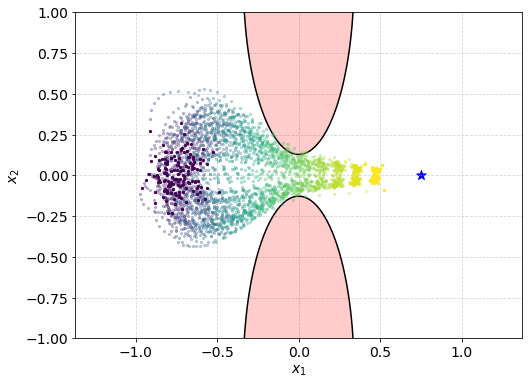

In [51]:
scatter_mbar_fixed(G_NN_list,
                   iteration=21,      # k = 4
                   n_vis=150,        # 150 trajectoires
                   x0=x0,
                   num_samples=300,
                   timesteps=20,
                   device="cuda")

In [50]:
np.savez('x0_plot.npz', x0=x0)

In [1]:
1

1

In [5]:
import numpy as np
np.random.normal(loc=0.0, scale=0.001, size=8)

array([-0.00031834,  0.0015021 ,  0.00067352,  0.0021363 , -0.0016973 ,
       -0.00073342,  0.00021364,  0.00053054])

In [ ]:
import math
from model import *
import numpy as np 
import torch 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
def gen_x0(num_samples, Torch=False):

        mu = np.array([[-0.75, 0.] + [0] * (2 - 2)], dtype=np.float32)
        samples = np.sqrt(0.01) * np.random.randn(num_samples, 2) + mu

        if Torch:
            return torch.tensor(samples, dtype=torch.float32, device=device)
        else:
            return samples
class ObstacleField:
    def __init__(self, linspace_size=100, lam_obstacle=1.0):
        self.linspace_size = linspace_size
        self.env = lambda: None
        self.env.lam_obstacle = lam_obstacle

    def FF_obstacle_func(self, x, y):
        """
        Two-diagonal obstacles confined to the interval [-1, 1] x [-1, 1].
        """
        theta = np.pi / 0.5
        rot_mat = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta),  np.cos(theta)]
        ], dtype=float)

        # Obstacle 1
        center1 = np.array([0., 0.3])
        vec1 = np.array([x, y]) - center1
        vec1 = np.dot(vec1, rot_mat)
        mat1 = np.array([[10, 0], [0, 1]])
        bb1 = np.array([0, 3])
        quad1 = np.dot(vec1, np.dot(mat1, vec1))
        lin1 = np.dot(vec1, bb1)
        out1 = np.clip(-1 * (quad1 + lin1 + 1), a_min=-0.1, a_max=None)

        # Obstacle 2
        center2 = np.array([0., -0.3])
        vec2 = np.array([x, y]) - center2
        vec2 = np.dot(vec2, rot_mat)
        mat2 = np.array([[10, 0], [0, 1]])
        bb2 = np.array([0, -3])
        quad2 = np.dot(vec2, np.dot(mat2, vec2))
        lin2 = np.dot(vec2, bb2)
        out2 = np.clip(-1 * (quad2 + lin2 + 1), a_min=-0.1, a_max=None)

        return out1 + out2

    def _make_obstacle_contours(self):
        self.plot_window_size = 1
        xlin = np.linspace(-self.plot_window_size, self.plot_window_size, self.linspace_size)
        ylin = np.linspace(-self.plot_window_size, self.plot_window_size, self.linspace_size)
        X, Y = np.meshgrid(xlin, ylin)
        vec_func = np.vectorize(self.FF_obstacle_func)
        Z = self.env.lam_obstacle * vec_func(X, Y)
        return X, Y, Z
    
def scatter_mbar_fixed(
                       G_NN_list,
                       iteration,              # k
                       n_vis=200,              # traj. affichées
                       x0=None,
                       num_samples=500,
                       timesteps=20,
                       device="cpu",
                       save_name="mbar_fixed.png",
                       obstacle=True):

    rng = np.random.default_rng()

    # ─── 1) état initial ─────────────────────────────────────────────
    if x0 is None:
        x0_full = gen_x0(num_samples).astype(np.float32)
    else:
        x0_full = x0.astype(np.float32)
        num_samples = x0_full.shape[0]

    d = x0_full.shape[1]
    if d < 2:
        raise ValueError("Dimension d ≥ 2 requise.")
    if n_vis > num_samples:
        raise ValueError("n_vis > taille de l’échantillon initial")

    # sous-échantillon fixe pour l’affichage
    i_idx = rng.choice(num_samples, size=n_vis, replace=False)
    x0    = x0_full[i_idx]                                      # (n_vis,d)

    gens =  G_NN_list       # longueur K=k+1
    K    = len(gens)

    # ─── 3) grille temps & batch (t,x) ─────────────────────────
    T1     = timesteps + 1
    t_grid = torch.linspace(0., 1., T1, device=device)
    t_test = t_grid.repeat_interleave(n_vis).view(-1, 1)

    x_rep  = np.tile(x0, (T1, 1))
    x_test = torch.tensor(x_rep, dtype=torch.float32, device=device)

    # ─── 4) trajectoires (K,T1,n_vis,d) ─────────────────────────
    X_all = []
    for G in gens:
        with torch.no_grad():
            X = G(t_test, x_test).cpu().numpy()
        X_all.append(X.reshape(T1, n_vis, d))
    X_all = np.stack(X_all, axis=0)                             # (K,T1,n_vis,d)

    # ─── 5) mélange uniforme : tirer g∈{0,…,k} pour CHAQUE trajet fixe
    g_idx = rng.integers(0, K, size=n_vis)                      # (n_vis,)
    traj  = X_all[g_idx, :, np.arange(n_vis), :]                # (n_vis,T1,d)

    # ─── 6) scatter (d = 2 ou d ≥ 4) ───────────────────────────
    colours = cm.viridis(np.linspace(0, 1, T1))
    fig, ax  = plt.subplots(figsize=(8, 6))

    if obstacle:
        of = ObstacleField()
        Xc, Yc, Zc = of._make_obstacle_contours()
        ax.contourf(Xc, Yc, Zc, levels=[0.001, np.max(Zc)],
                    colors='red', alpha=0.2, zorder=2)
        ax.contour(Xc, Yc, Zc, levels=[0], colors='black',
                   linewidths=1.5, zorder=2)

    for j, c in enumerate(colours):
        alpha = 1.0 if j in (0, timesteps) else 0.3
        ax.scatter(traj[:, j, 0], traj[:, j, 1],
                   color=c, alpha=alpha, s=5,
                   zorder=10 if alpha == 1 else 6)

    ax.scatter(0.75, 0.0, color="blue", marker="*", s=100)
#     ax.set_title(fr"$\bar m_{{{iteration}}}$  –  {n_vis} traj. fixes",
#                  fontsize=14)
    ax.set_xlabel(r"$x_1$", fontsize=14); ax.set_ylabel(r"$x_2$", fontsize=14)
    ax.axis("equal"); ax.grid(True, linestyle="--", alpha=0.5)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.savefig(save_name, dpi=300, bbox_inches='tight'); plt.show()


paths = ["G_NNN_round0_n7.pth"]



device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
G_NN_list = []
data = np.load('data1.npz') 
x0_ini = torch.tensor(data['x'], dtype=torch.float32, device=device)
m0 = x0_ini
mu = x0_ini.mean(axis=0)
std = torch.sqrt(x0_ini.var(axis=0))
act_func=lambda x: torch.relu(x)

for p in paths:
    model = G_Net(dim=2, ns=128, act_func=act_func, hh=0.5,
                            device=device, mu=mu, std=std,  TT=1).to(device)
    state = torch.load(p, map_location=device)
    model.load_state_dict(state)
    model.eval()
    G_NN_list.append(model)



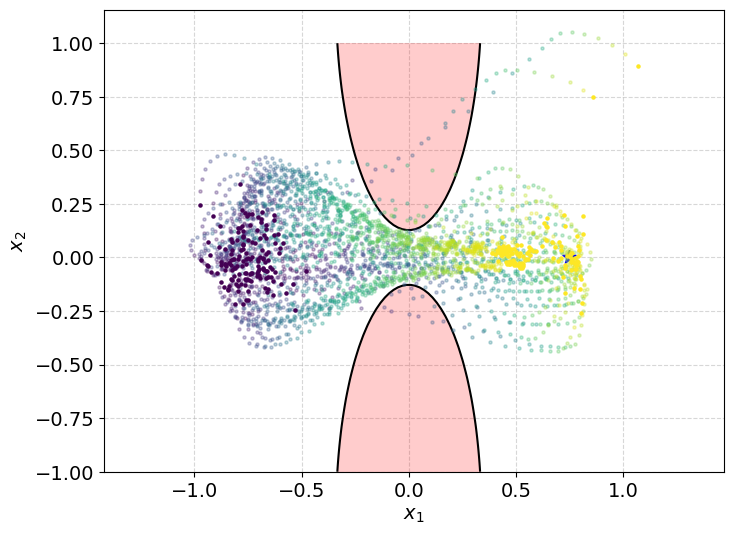

In [50]:
x0 = gen_x0(300).astype(np.float32)
scatter_mbar_fixed(G_NN_list,
                   iteration=21,      # k = 4
                   n_vis=150,        # 150 trajectoires
                   x0=x0,
                   num_samples=300,
                   timesteps=20,
                   device="cpu")


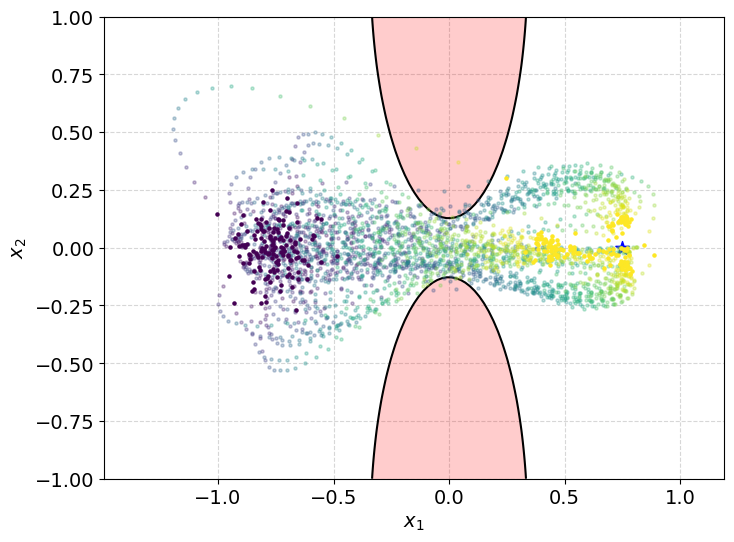

In [6]:
import math
from model import *
import numpy as np 
import torch 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
def gen_x0(num_samples, Torch=False):

        mu = np.array([[-0.75, 0.] + [0] * (10 - 2)], dtype=np.float32)
        samples = np.sqrt(0.01) * np.random.randn(num_samples, 10) + mu

        if Torch:
            return torch.tensor(samples, dtype=torch.float32, device=device)
        else:
            return samples
class ObstacleField:
    def __init__(self, linspace_size=100, lam_obstacle=1.0):
        self.linspace_size = linspace_size
        self.env = lambda: None
        self.env.lam_obstacle = lam_obstacle

    def FF_obstacle_func(self, x, y):
        """
        Two-diagonal obstacles confined to the interval [-1, 1] x [-1, 1].
        """
        theta = np.pi / 0.5
        rot_mat = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta),  np.cos(theta)]
        ], dtype=float)

        # Obstacle 1
        center1 = np.array([0., 0.3])
        vec1 = np.array([x, y]) - center1
        vec1 = np.dot(vec1, rot_mat)
        mat1 = np.array([[10, 0], [0, 1]])
        bb1 = np.array([0, 3])
        quad1 = np.dot(vec1, np.dot(mat1, vec1))
        lin1 = np.dot(vec1, bb1)
        out1 = np.clip(-1 * (quad1 + lin1 + 1), a_min=-0.1, a_max=None)

        # Obstacle 2
        center2 = np.array([0., -0.3])
        vec2 = np.array([x, y]) - center2
        vec2 = np.dot(vec2, rot_mat)
        mat2 = np.array([[10, 0], [0, 1]])
        bb2 = np.array([0, -3])
        quad2 = np.dot(vec2, np.dot(mat2, vec2))
        lin2 = np.dot(vec2, bb2)
        out2 = np.clip(-1 * (quad2 + lin2 + 1), a_min=-0.1, a_max=None)

        return out1 + out2

    def _make_obstacle_contours(self):
        self.plot_window_size = 1
        xlin = np.linspace(-self.plot_window_size, self.plot_window_size, self.linspace_size)
        ylin = np.linspace(-self.plot_window_size, self.plot_window_size, self.linspace_size)
        X, Y = np.meshgrid(xlin, ylin)
        vec_func = np.vectorize(self.FF_obstacle_func)
        Z = self.env.lam_obstacle * vec_func(X, Y)
        return X, Y, Z
    
def scatter_mbar_fixed(
                       G_NN_list,
                       iteration,              # k
                       n_vis=200,              # traj. affichées
                       x0=None,
                       num_samples=500,
                       timesteps=20,
                       device="cpu",
                       save_name="mbar_fixed.png",
                       obstacle=True):

    rng = np.random.default_rng()

    # ─── 1) état initial ─────────────────────────────────────────────
    if x0 is None:
        x0_full = gen_x0(num_samples).astype(np.float32)
    else:
        x0_full = x0.astype(np.float32)
        num_samples = x0_full.shape[0]

    d = x0_full.shape[1]
    if d < 2:
        raise ValueError("Dimension d ≥ 2 requise.")
    if n_vis > num_samples:
        raise ValueError("n_vis > taille de l’échantillon initial")

    # sous-échantillon fixe pour l’affichage
    i_idx = rng.choice(num_samples, size=n_vis, replace=False)
    x0    = x0_full[i_idx]                                      # (n_vis,d)

    gens =  G_NN_list       # longueur K=k+1
    K    = len(gens)

    # ─── 3) grille temps & batch (t,x) ─────────────────────────
    T1     = timesteps + 1
    t_grid = torch.linspace(0., 1., T1, device=device)
    t_test = t_grid.repeat_interleave(n_vis).view(-1, 1)

    x_rep  = np.tile(x0, (T1, 1))
    x_test = torch.tensor(x_rep, dtype=torch.float32, device=device)

    # ─── 4) trajectoires (K,T1,n_vis,d) ─────────────────────────
    X_all = []
    for G in gens:
        with torch.no_grad():
            X = G(t_test, x_test).cpu().numpy()
        X_all.append(X.reshape(T1, n_vis, d))
    X_all = np.stack(X_all, axis=0)                             # (K,T1,n_vis,d)

    # ─── 5) mélange uniforme : tirer g∈{0,…,k} pour CHAQUE trajet fixe
    g_idx = rng.integers(0, K, size=n_vis)                      # (n_vis,)
    traj  = X_all[g_idx, :, np.arange(n_vis), :]                # (n_vis,T1,d)

    # ─── 6) scatter (d = 2 ou d ≥ 4) ───────────────────────────
    colours = cm.viridis(np.linspace(0, 1, T1))
    fig, ax  = plt.subplots(figsize=(8, 6))

    if obstacle:
        of = ObstacleField()
        Xc, Yc, Zc = of._make_obstacle_contours()
        ax.contourf(Xc, Yc, Zc, levels=[0.001, np.max(Zc)],
                    colors='red', alpha=0.2, zorder=2)
        ax.contour(Xc, Yc, Zc, levels=[0], colors='black',
                   linewidths=1.5, zorder=2)

    for j, c in enumerate(colours):
        alpha = 1.0 if j in (0, timesteps) else 0.3
        ax.scatter(traj[:, j, 0], traj[:, j, 1],
                   color=c, alpha=alpha, s=5,
                   zorder=10 if alpha == 1 else 6)

    ax.scatter(0.75, 0.0, color="blue", marker="*", s=100)
#     ax.set_title(fr"$\bar m_{{{iteration}}}$  –  {n_vis} traj. fixes",
#                  fontsize=14)
    ax.set_xlabel(r"$x_1$", fontsize=14); ax.set_ylabel(r"$x_2$", fontsize=14)
    ax.axis("equal"); ax.grid(True, linestyle="--", alpha=0.5)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.savefig(save_name, dpi=300, bbox_inches='tight'); plt.show()


paths = ["G_NNN_round0_n15.pth","G_NNN_round0_n16.pth","G_NNN_round0_n17.pth","G_NNN_round0_n17.pth","G_NNN_round0_n18.pth"]



device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
G_NN_list = []
data = np.load('data10.npz') 
x0_ini = torch.tensor(data['x'], dtype=torch.float32, device=device)
m0 = x0_ini
mu = x0_ini.mean(axis=0)
std = torch.sqrt(x0_ini.var(axis=0))
act_func=lambda x: torch.relu(x)

for p in paths:
    model = G_Net(dim=10, ns=128, act_func=act_func, hh=0.5,
                            device=device, mu=mu, std=std,  TT=1).to(device)
    state = torch.load(p, map_location=device)
    model.load_state_dict(state)
    model.eval()
    G_NN_list.append(model)



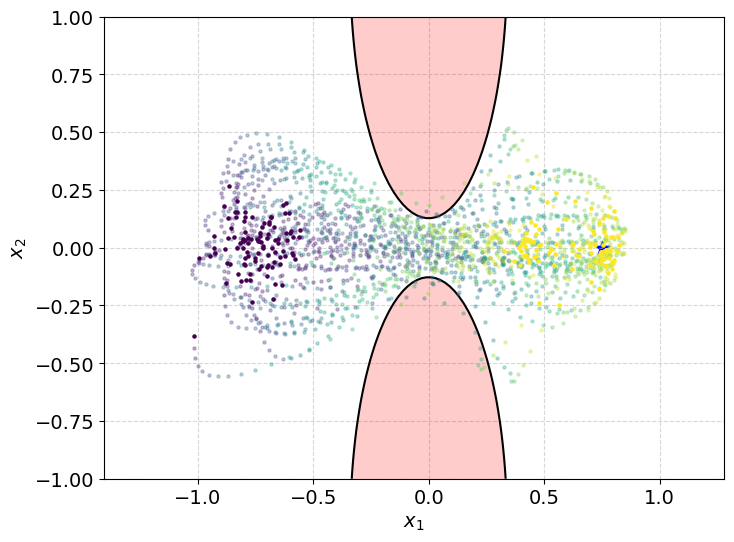

In [24]:
x0 = gen_x0(200).astype(np.float32)
scatter_mbar_fixed(G_NN_list,
                   iteration=21,      # k = 4
                   n_vis=100,        # 150 trajectoires
                   x0=x0,
                   num_samples=300,
                   timesteps=20,
                   device="cpu")


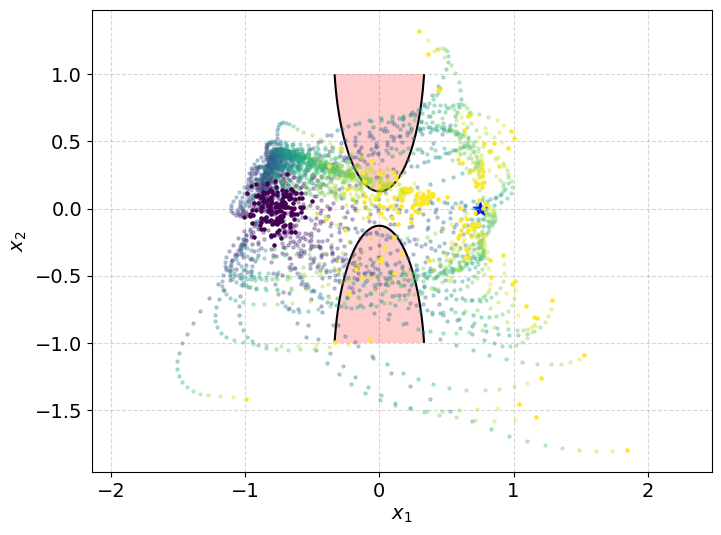

: 

: 

In [ ]:
scatter_mbar_fixed(G_NN_list,
                   iteration=21,      # k = 4
                   n_vis=150,        # 150 trajectoires
                   x0=x0,
                   num_samples=300,
                   timesteps=20,
                   device="cpu")

In [ ]:
import math
from model import *
import numpy as np 
import torch 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
def gen_x0(num_samples, Torch=False):

        mu = np.array([[-0.75, 0.] + [0] * (2 - 2)], dtype=np.float32)
        samples = np.sqrt(0.01) * np.random.randn(num_samples, 2) + mu

        if Torch:
            return torch.tensor(samples, dtype=torch.float32, device=device)
        else:
            return samples
class ObstacleField:
    def __init__(self, linspace_size=100, lam_obstacle=1.0):
        self.linspace_size = linspace_size
        self.env = lambda: None
        self.env.lam_obstacle = lam_obstacle

    def FF_obstacle_func(self, x, y):
        """
        Two-diagonal obstacles confined to the interval [-1, 1] x [-1, 1].
        """
        theta = np.pi / 0.5
        rot_mat = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta),  np.cos(theta)]
        ], dtype=float)

        # Obstacle 1
        center1 = np.array([0., 0.3])
        vec1 = np.array([x, y]) - center1
        vec1 = np.dot(vec1, rot_mat)
        mat1 = np.array([[10, 0], [0, 1]])
        bb1 = np.array([0, 3])
        quad1 = np.dot(vec1, np.dot(mat1, vec1))
        lin1 = np.dot(vec1, bb1)
        out1 = np.clip(-1 * (quad1 + lin1 + 1), a_min=-0.1, a_max=None)

        # Obstacle 2
        center2 = np.array([0., -0.3])
        vec2 = np.array([x, y]) - center2
        vec2 = np.dot(vec2, rot_mat)
        mat2 = np.array([[10, 0], [0, 1]])
        bb2 = np.array([0, -3])
        quad2 = np.dot(vec2, np.dot(mat2, vec2))
        lin2 = np.dot(vec2, bb2)
        out2 = np.clip(-1 * (quad2 + lin2 + 1), a_min=-0.1, a_max=None)

        return out1 + out2

    def _make_obstacle_contours(self):
        self.plot_window_size = 1
        xlin = np.linspace(-self.plot_window_size, self.plot_window_size, self.linspace_size)
        ylin = np.linspace(-self.plot_window_size, self.plot_window_size, self.linspace_size)
        X, Y = np.meshgrid(xlin, ylin)
        vec_func = np.vectorize(self.FF_obstacle_func)
        Z = self.env.lam_obstacle * vec_func(X, Y)
        return X, Y, Z
    
def scatter_mbar_fixed(
                       G_NN_list,
                       iteration,              # k
                       n_vis=200,              # traj. affichées
                       x0=None,
                       num_samples=500,
                       timesteps=20,
                       device="cpu",
                       save_name="mbar_fixed.png",
                       obstacle=True):

    rng = np.random.default_rng()

    # ─── 1) état initial ─────────────────────────────────────────────
    if x0 is None:
        x0_full = gen_x0(num_samples).astype(np.float32)
    else:
        x0_full = x0.astype(np.float32)
        num_samples = x0_full.shape[0]

    d = x0_full.shape[1]
    if d < 2:
        raise ValueError("Dimension d ≥ 2 requise.")
    if n_vis > num_samples:
        raise ValueError("n_vis > taille de l’échantillon initial")

    # sous-échantillon fixe pour l’affichage
    i_idx = rng.choice(num_samples, size=n_vis, replace=False)
    x0    = x0_full[i_idx]                                      # (n_vis,d)

    gens =  G_NN_list       # longueur K=k+1
    K    = len(gens)

    # ─── 3) grille temps & batch (t,x) ─────────────────────────
    T1     = timesteps + 1
    t_grid = torch.linspace(0., 1., T1, device=device)
    t_test = t_grid.repeat_interleave(n_vis).view(-1, 1)

    x_rep  = np.tile(x0, (T1, 1))
    x_test = torch.tensor(x_rep, dtype=torch.float32, device=device)

    # ─── 4) trajectoires (K,T1,n_vis,d) ─────────────────────────
    X_all = []
    for G in gens:
        with torch.no_grad():
            X = G(t_test, x_test).cpu().numpy()
        X_all.append(X.reshape(T1, n_vis, d))
    X_all = np.stack(X_all, axis=0)                             # (K,T1,n_vis,d)

    # ─── 5) mélange uniforme : tirer g∈{0,…,k} pour CHAQUE trajet fixe
    g_idx = rng.integers(0, K, size=n_vis)                      # (n_vis,)
    traj  = X_all[g_idx, :, np.arange(n_vis), :]                # (n_vis,T1,d)

    # ─── 6) scatter (d = 2 ou d ≥ 4) ───────────────────────────
    colours = cm.viridis(np.linspace(0, 1, T1))
    fig, ax  = plt.subplots(figsize=(8, 6))

    if obstacle:
        of = ObstacleField()
        Xc, Yc, Zc = of._make_obstacle_contours()
        ax.contourf(Xc, Yc, Zc, levels=[0.001, np.max(Zc)],
                    colors='red', alpha=0.2, zorder=2)
        ax.contour(Xc, Yc, Zc, levels=[0], colors='black',
                   linewidths=1.5, zorder=2)

    for j, c in enumerate(colours):
        alpha = 1.0 if j in (0, timesteps) else 0.3
        ax.scatter(traj[:, j, 0], traj[:, j, 1],
                   color=c, alpha=alpha, s=5,
                   zorder=10 if alpha == 1 else 6)

    ax.scatter(0.75, 0.0, color="blue", marker="*", s=100)
#     ax.set_title(fr"$\bar m_{{{iteration}}}$  –  {n_vis} traj. fixes",
#                  fontsize=14)
    ax.set_xlabel(r"$x_1$", fontsize=14); ax.set_ylabel(r"$x_2$", fontsize=14)
    ax.axis("equal"); ax.grid(True, linestyle="--", alpha=0.5)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.savefig(save_name, dpi=300, bbox_inches='tight'); plt.show()


paths = ["G_NNN2_round0_n14.pth", "G_NNN2_round1_n0.pth", "G_NNN2_round1_n1.pth", "G_NNN2_round1_n2.pth", "G_NNN2_round1_n3.pth",
        "G_NNN2_round1_n4.pth", "G_NNN2_round1_n5.pth", "G_NNN2_round1_n6.pth", "G_NNN2_round1_n7.pth", "G_NNN2_round1_n8.pth", "G_NNN2_round1_n9.pth",
        "G_NNN2_round1_n10.pth", "G_NNN2_round1_n11.pth", "G_NNN2_round1_n12.pth", "G_NNN2_round1_n13.pth"]

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
G_NN_list = []
data = np.load('data1.npz') 
x0_ini = torch.tensor(data['x'], dtype=torch.float32, device=device)
m0 = x0_ini
mu = x0_ini.mean(axis=0)
std = torch.sqrt(x0_ini.var(axis=0))
act_func=lambda x: torch.relu(x)

for p in paths:
    model = G_Net(dim=2, ns=128, act_func=act_func, hh=0.5,
                            device=device, mu=mu, std=std,  TT=1).to(device)
    state = torch.load(p, map_location=device)
    model.load_state_dict(state)
    model.eval()
    G_NN_list.append(model)



<ipython-input-6-06ee7b5cd8d2>:159: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(p, map_location=device)


: 

: 

In [ ]:
x0 = gen_x0(300).astype(np.float32)

: 

: 

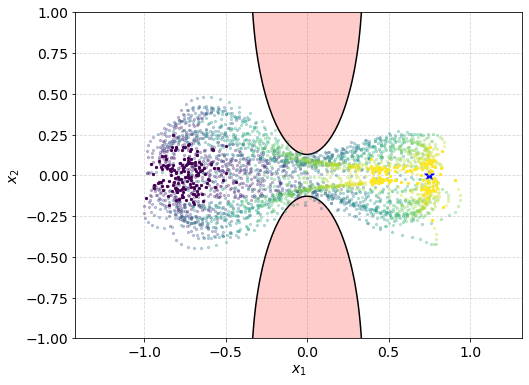

: 

: 

In [ ]:
scatter_mbar_fixed(G_NN_list,
                   iteration=21,      # k = 4
                   n_vis=150,        # 150 trajectoires
                   x0=x0,
                   num_samples=300,
                   timesteps=20,
                   device="cuda")

In [ ]:
from matplotlib.animation import FFMpegWriter, PillowWriter

def save_video(anim, out_base="crowd_200_video", fps=30, dpi=180):
    # write to the current folder to avoid path issues
    tried = []
    for codec, extra in [
        ("libx264", ['-pix_fmt','yuv420p','-crf','23','-preset','veryfast']),
        ("mpeg4",   ['-q:v','3'])
    ]:
        try:
            out_mp4 = f"{out_base}.mp4"
            writer = FFMpegWriter(fps=fps, codec=codec, extra_args=extra)
            anim.save(out_mp4, writer=writer, dpi=dpi)
            print(out_mp4)   # <- single link/path
            return out_mp4
        except Exception as e:
            tried.append((codec, str(e)))

    # If both codecs fail, uncomment the 2 lines below to at least get a GIF:
    # out_gif = f"{out_base}.gif"
    # anim.save(out_gif, writer=PillowWriter(fps=min(fps,20)), dpi=dpi); print(out_gif); return out_gif

    raise RuntimeError(f"FFmpeg failed for {tried}")


: 

: 

<ipython-input-43-5e89ce6071f5>:173: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(p, map_location=device)


avid.mp4
Saved to: avid.mp4


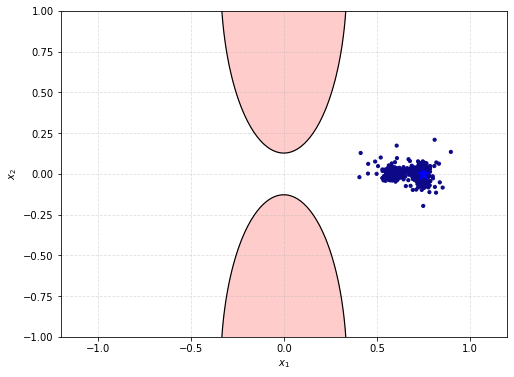

: 

: 

In [ ]:
# ============================================
# Animate ALL 200 agents simultaneously (slower, violet→yellow)
# ============================================
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter, PillowWriter
from model import *  # your G_Net, etc.

# -------- Helpers --------
def gen_x0(num_samples, Torch=False, device="cpu"):
    mu = np.array([[-0.75, 0.]], dtype=np.float32)
    samples = np.sqrt(0.01) * np.random.randn(num_samples, 2) + mu
    if Torch:
        return torch.tensor(samples, dtype=torch.float32, device=device)
    return samples

class ObstacleField:
    def __init__(self, linspace_size=120, lam_obstacle=1.0):
        self.linspace_size = linspace_size
        self.env = lambda: None
        self.env.lam_obstacle = lam_obstacle

    def FF_obstacle_func(self, x, y):
        theta = np.pi / 0.5
        rot = np.array([[np.cos(theta), -np.sin(theta)],
                        [np.sin(theta),  np.cos(theta)]], dtype=float)
        # obstacle 1 (upper)
        c1 = np.array([0.,  0.3])
        v1 = (np.array([x, y]) - c1) @ rot
        M  = np.array([[10, 0], [0, 1]])
        b1 = np.array([0, 3])
        out1 = np.clip(-1 * (v1 @ (M @ v1) + v1 @ b1 + 1), a_min=-0.1, a_max=None)
        # obstacle 2 (lower)
        c2 = np.array([0., -0.3])
        v2 = (np.array([x, y]) - c2) @ rot
        b2 = np.array([0, -3])
        out2 = np.clip(-1 * (v2 @ (M @ v2) + v2 @ b2 + 1), a_min=-0.1, a_max=None)
        return (out1 + out2) * self.env.lam_obstacle

    def make_contours(self):
        w = 1.0
        x = np.linspace(-w, w, self.linspace_size)
        y = np.linspace(-w, w, self.linspace_size)
        X, Y = np.meshgrid(x, y)
        Z = np.vectorize(self.FF_obstacle_func)(X, Y)
        return X, Y, Z

# -------- Core animation (time-driven) --------
def animate_all_agents(
    G_NN_list,
    n_vis=200,                 # show 200 agents at once
    x0=None,
    num_samples=500,
    timesteps=20,
    device=None,
    save_base="",   # output file prefix
    fps=10,                         # LOWER FPS -> slower playback
    hold_start=12,                  # hold initial frame to slow down start
    hold_end=18                     # hold final frame to slow down end
):
    if device is None:
        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    rng = np.random.default_rng()

    # 1) initial cloud
    if x0 is None:
        x0_full = gen_x0(num_samples).astype(np.float32)
    else:
        x0_full = x0.astype(np.float32)
        num_samples = x0_full.shape[0]

    assert x0_full.shape[1] >= 2, "Need d ≥ 2."
    assert n_vis <= num_samples, "n_vis cannot exceed initial sample size."

    idx = rng.choice(num_samples, size=n_vis, replace=False)
    x0_vis = x0_full[idx]  # (n_vis, 2)

    # 2) build (t, x) batch
    T1 = timesteps + 1
    t_grid = torch.linspace(0., 1.05, T1, device=device)
    t_test = t_grid.repeat_interleave(n_vis).view(-1, 1)     # ((T1*n_vis), 1)
    x_rep  = np.tile(x0_vis, (T1, 1))                        # ((T1*n_vis), 2)
    x_test = torch.tensor(x_rep, dtype=torch.float32, device=device)

    # 3) push through all generators -> X_all: (K, T1, n_vis, 2)
    X_all = []
    for G in G_NN_list:
        with torch.no_grad():
            X = G(t_test, x_test).detach().cpu().numpy().reshape(T1, n_vis, 2)
        X_all.append(X)
    X_all = np.stack(X_all, axis=0)          # (K, T1, n_vis, 2)
    K = X_all.shape[0]

    # 4) uniform mix: one generator per trajectory (fixed)
    g_idx = rng.integers(0, K, size=n_vis)   # (n_vis,)
    frames = np.empty((T1, n_vis, 2), dtype=float)
    for i in range(n_vis):
        frames[:, i, :] = X_all[g_idx[i], :, i, :]  # each agent uses its own generator

    # 5) figure & static background
    fig, ax = plt.subplots(figsize=(8, 6))
    of = ObstacleField()
    Xc, Yc, Zc = of.make_contours()
    ax.contourf(Xc, Yc, Zc, levels=[0.001, np.max(Zc)], colors='red', alpha=0.20, zorder=1)
    ax.contour(Xc, Yc, Zc, levels=[0], colors='black', linewidths=1.2, zorder=2)

    ax.scatter(0.75, 0.0, color="blue", marker="*", s=140, zorder=12, label="Target")
    ax.set_xlim(-1.2, 1.2); ax.set_ylim(-1.0, 1.0)
    ax.set_xlabel(r"$x_1$"); ax.set_ylabel(r"$x_2$")
    ax.grid(True, linestyle="--", alpha=0.4)


    # color map: 'plasma' goes violet → yellow
    scat = ax.scatter([], [], s=10, cmap="plasma", c=[], zorder=10)

    # 6) build a slower frame schedule (hold at start/end)
    frame_schedule = [0] * hold_start + list(range(T1)) + [T1 - 1] * hold_end
    total_frames = len(frame_schedule)

    def init():
        scat.set_offsets(np.empty((0, 2)))
        scat.set_array(np.array([]))
        return scat,

    def update(fi):
        t = frame_schedule[fi]            # which true time step to show
        pts = frames[t]                   # (n_vis, 2) — ALL agents at this time
        colour_val = t / (T1 - 1)         # 0.0 (violet) → 1.0 (yellow)
        scat.set_offsets(pts)
        scat.set_array(np.full(n_vis, colour_val))
        return scat,

    anim = FuncAnimation(fig, update, init_func=init, frames=total_frames, blit=True)

    # 7) save: MP4 (mpeg4+yuv420p), fallback GIF
    def save(anim, base, fps=10, dpi=180):
        try:
            writer = FFMpegWriter(fps=fps, codec="mpeg4",
                                  extra_args=['-pix_fmt', 'yuv420p', '-q:v', '3'])
            out = f"{base}.mp4"
            anim.save(out, writer=writer, dpi=dpi)
            print(out)
            return out
        except Exception:
            out = f"{base}.gif"
            anim.save(out, writer=PillowWriter(fps=min(fps, 20)), dpi=dpi)
            print(out)
            return out

    return save(anim, base=save_base, fps=fps, dpi=180)

# -------- Load your generators (same as your script) --------
paths = [
    "G_NNN2_round0_n14.pth",
    "G_NNN2_round1_n0.pth",  "G_NNN2_round1_n1.pth",  "G_NNN2_round1_n2.pth",  "G_NNN2_round1_n3.pth",
    "G_NNN2_round1_n4.pth",  "G_NNN2_round1_n5.pth",  "G_NNN2_round1_n6.pth",  "G_NNN2_round1_n7.pth",
    "G_NNN2_round1_n8.pth",  "G_NNN2_round1_n9.pth",  "G_NNN2_round1_n10.pth", "G_NNN2_round1_n11.pth",
    "G_NNN2_round1_n12.pth", "G_NNN2_round1_n13.pth"
]

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
data = np.load('data1.npz')
x0_ini = torch.tensor(data['x'], dtype=torch.float32, device=device)
mu = x0_ini.mean(axis=0); std = torch.sqrt(x0_ini.var(axis=0))
act_func = lambda x: torch.relu(x)

G_NN_list = []
for p in paths:
    model = G_Net(dim=2, ns=128, act_func=act_func, hh=0.5,
                  device=device, mu=mu, std=std, TT=1).to(device)
    state = torch.load(p, map_location=device)
    model.load_state_dict(state); model.eval()
    G_NN_list.append(model)

# -------- Run (ALL 200 at once, slower, violet→yellow) --------
out_file = animate_all_agents(
    G_NN_list,
    n_vis=500,               # 200 agents at once
    x0=None,                 # or: gen_x0(300).astype(np.float32)
    num_samples=1000,
    timesteps=20,
    device=device,
    save_base="avid",  # creates .mp4 (or .gif)
    fps=10, hold_start=12, hold_end=18
)
print("Saved to:", out_file)


: 

: 